#Initialization

In [1]:
import datetime
tme = datetime.datetime.utcnow()+datetime.timedelta(hours=2)
print(tme.strftime('%H:%M:%S'))

05:55:41


In [2]:
Direct_YOLO_Detection = True
if Direct_YOLO_Detection:
    Yolo_Direct_Weights = "/content/drive/MyDrive/YoloWeights/Yolo5/Yolo5s-WeapRef-1CWs320.pt" #custom path

Direct_Mask_Detection = False
if Direct_Mask_Detection:
    Mask_Direct_Weights = "/content/drive/MyDrive/NewWeights/Mask_Classifier_1.pt" #custom path
    XG_weights_path = "/content/XG.json" #custom path


In [3]:
# Deletion of any non empty folder

#import shutil
#shutil.rmtree('/content/NewCode') # put the path you want to delete

#Set initial path

%cd /content

/content


In [4]:
running_on_vm = True
#false --> running on colab
#true  --> running on vm

In [5]:
delete_previous_data_set = True
# in case of running on vm
  #false --> keep previous dataset that was downloaded from robowflow
  #true  --> delete previous dataset

In [6]:
code_exists_on_vm = False
# in case of running on vm
  #false --> download the code or modify it from github
  #true  --> dont download code from github or modify it

In [7]:
#SAVE EVERY NUMBER OF EPOCHS
save_per_num_of_epochs = 0

In [8]:
#Yolo Parameters
YoloVersion = "v5"          # v5 v8
YOLO_Conf_Thresh = .15
YOLO_Overlap_Thresh = .45
set_batch = 32

yolo_epochs = 1000
yolo_early_stopping = 100   # 0 if no Early Stopping
yolo_image_size = 320       # 640 / 448 / 320

#Classifier Parameters
Model_Name = "R101" # R101 R50 R18 V16

mask_epochs =100
mask_LR = 0.01
mask_sched_step_size = 16    # i.e. decay every 3 epochs
mask_sched_gamma = 0.1      # i.e. decay LR by 0.1
mask_weight_decay = 0.0005  # regularization factor to prevent overfitting, default 0.0005 , increase to prevent overfitting

Mask_THRESH = 0  # to be set by auto Thr. cell
init_Mask_THRESH = 0.4

sel_optimizer = "sgd"       #  (adam, nadam, sgd, ...)
sel_activation = "sm"       # (sm, sg)
Apply_Calibration = True    # away to make the probabilites is not biased to 0 and 1 but diff. figures between for each classes
                            # if used so, the activation fn. is not used
dummy_index = -1
#Using XGBoost
XGBoost_LR = 0.1
XGBoost_n_estimators=120
Apply_XG = False

#Full Model with Ensamble
ALL_THRESH = .10
Ensemble_method = 0         # 0--> standard, 1--> modified
###### if any of them = -1 then this values will be retrieved from training accuracy ######
Mask_Factor = -1            # default = -1 take values from training accuracy
Yolo_Factor = -1            # default = -1 take values from training accuracy

#Direct Detection Mode
if Direct_YOLO_Detection:
    yolo_epochs = 0
if Direct_Mask_Detection:
    mask_epochs = 0

In [9]:
def activationFunction(z):
  if sel_activation == "sg": # Sigmoid
    return 1/(1+np.exp(-z))
  if sel_activation == "sm": # Softmax
    e_x = np.exp(z - np.max(z))
    return e_x / e_x.sum()

In [10]:
mainfolderpath=''

if running_on_vm:
  mainfolderpath='/content/NewCode'
else:
  mainfolderpath='/content'

%cd $mainfolderpath

/content/NewCode


In [11]:
import shutil
if running_on_vm:
    try:
        shutil.rmtree('yolo'+ YoloVersion +'/runs')
        shutil.rmtree('results')
    except:
        No_Error = 0

In [12]:
if running_on_vm and (not(code_exists_on_vm)) :
    try:
        shutil.rmtree('yolo'+ YoloVersion)
    except:
        No_Error = 0

In [13]:
#MOUNT GOOGLE DRIVE
if not running_on_vm:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)

In [14]:
import warnings;
warnings.filterwarnings('ignore');

In [15]:
if YoloVersion == "v5":
  default_yolo_weights_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/train/yolo' + YoloVersion + 's_results/weights/best.pt'
if YoloVersion == "v8":
  default_yolo_weights_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/detect/train/weights/best.pt'

if YoloVersion == "v5":
  exp_folder = "exp"
if YoloVersion == "v8":
  exp_folder = "predict"

if Direct_YOLO_Detection:
    yolo_w_path = Yolo_Direct_Weights
else:
    yolo_w_path = default_yolo_weights_path

# Importing

In [16]:
#ORDER THE CALLBACKS DURING TRAINING

#!pip install numpy==1.16.1
#!pip install --force-reinstall numpy==1.18.5
import tensorflow as tf
from tensorflow import keras
from google.colab import files
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import pandas as pd
import os
from glob import glob
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np

import torch
import torchvision
import torch.nn.functional as F
from torchvision.models import vgg16_bn, VGG16_BN_Weights, resnet50, ResNet50_Weights, resnet101, ResNet101_Weights

from __future__ import print_function, division

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image

cudnn.benchmark = True
plt.ion()   # interac

import csv
import requests
import xml.etree.ElementTree as ET
import cv2
import shutil
from IPython.display import clear_output

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

#import xgboost

# Dataset Configuration and Initial Weights



In [17]:
if YoloVersion == "v5":
  #init_yolo = "yolov5s.pt"    # dummy weights for non Pre-Trained, network s
  #init_yolo = "yolov5m.pt"    # dummy weights for non Pre-Trained, network m

  init_yolo = "/content/drive/MyDrive/YoloWeights/Yolo5/yolov5s.pt"   # --> from drive for Pretrained weights with coco, network s
  #init_yolo = "/content/drive/MyDrive/YoloWeights/Yolo5/yolov5m.pt"   # --> from drive for Pretrained weights with coco, network m

  #init_yolo = "/content/drive/MyDrive/YoloWeights/Yolo5/yolov5s6.pt"  # --> from drive for Pretrained weights with imagenet
  #init_yolo = "/content/drive/MyDrive/YoloWeights/Yolo5/yolov5m6.pt"  # --> from drive for Pretrained weights with imagenet

  #init_yolo = "Custom path"  # --> write custom path here

if YoloVersion == "v8":
  #init_yolo = "yolov8s.pt"   # dummy weights for non pretrained , network s
  #init_yolo = "yolov8n.pt"   # dummy weights for non pretrained , network n

  init_yolo = "/content/drive/MyDrive/YoloWeights/Yolo8/yolov8s.pt" # --> from drive for Pretrained weights with "coco", network s
  #init_yolo = "/content/drive/MyDrive/YoloWeights/Yolo8/yolov8n.pt" # --> from drive for Pretrained weights with "coco", network n


In [18]:
# Pretrained weights is used through the pytorch itself according to the network used (ResNet101 - ResNet50 - VGG16)

###### Not Pre-Trained
#init_mask = None

######init_mask = "imagenet":
#init_mask = "/content/drive/MyDrive/NewWeights/imagenet-Classifier.h5"

######init_mask = "coco":
#init_mask = "/content/drive/MyDrive/NewWeights/coco-Classifier.h5"

#init_mask = "custom" # --> write custom path here

In [19]:
#class_names = ['Gun','dummy']
#class_names = ['Weapon','dummy']
#class_names = ['Gun' , 'LongGun' ,'dummy']
#class_names = ['Gun' , 'LongGun' , 'PartialGun','dummy']
#class_names = ['Gun' , 'LongGun' , 'NotGun' , 'PartialGun','dummy']

##class_names = ['Gun']
##class_names = ['Weapon']
#class_names = ['Gun' , 'LongGun']
#class_names = ['Gun' , 'LongGun' , 'PartialGun']
##class_names = ['Gun' , 'LongGun' , 'NotGun', 'PartialGun']

##class_names = ['Weapon']
class_names = ['Handgun' , 'Rifle']

#class_names = ['Face']
###class_names = ['with_mask' , 'without_mask' , 'mask_weared_incorrect']  not used with small initials due to order in cofusion matrix is alphabetical (dummy is small initial to be always the last)
#class_names = ['Mask_weared_incorrect' , 'With_mask' , 'Without_mask' , ] # classes is  labeled by its number , not name, so no problem for change initials to capital
#class_names = ['With_mask' , 'Without_mask']

number_of_classes = len(class_names)
print(number_of_classes)

2


In [20]:
import shutil
import os

%cd $mainfolderpath

if running_on_vm and delete_previous_data_set:
    try:
        shutil.rmtree('Mask_DS')
        shutil.rmtree('Yolo_DS')
        dest_paths = [mainfolderpath + '/test0_images',
              mainfolderpath + '/test1_images',
              mainfolderpath + '/test2_images',
              mainfolderpath + '/test3_images',
              mainfolderpath + '/test4_images']
        for path in dest_paths:
            shutil.rmtree(path)

    except:
        No_Error = 0

/content/NewCode


In [21]:
if (not running_on_vm) or (running_on_vm and delete_previous_data_set):
  path = mainfolderpath + '/Mask_DS'
  if not os.path.exists(path):
    os.makedirs(path)
  path = mainfolderpath + '/Yolo_DS'
  if not os.path.exists(path):
    os.makedirs(path)

  #####################################################    MASK DS   ######################################################
  path = mainfolderpath + '/Mask_DS'
  %cd $path

  #Dataset 1 class:
  if number_of_classes ==1:
    #YOLO V5:
    #========
    #DSW1 - 0 Original-S320       [2020]-2 images new-2389 instances
    #!curl -L "https://app.roboflow.com/ds/3YFapwuNvF?key=oqjxahiMpE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DSW1 - 0 Original-S448       [2020]-2 images new-2389 instances
    #!curl -L "https://app.roboflow.com/ds/sR5GPeb6QN?key=tEvVK85WRC" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DSW1 - 0 Original-S640       [2020]-2 images new-2389 instances
    #!curl -L "https://app.roboflow.com/ds/Uy0p7zqv8c?key=zSXEovmzIQ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DSW1 - 1 [2020]-2 >> Augm    [3419] images new-2389 instances
    #!curl -L "https://app.roboflow.com/ds/sWCBYLLnUE?key=zXqTqyrpG8" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DSW1 - 1 [2020]-2 >> bbxAugm [3419] images new-2389 instances
    #!curl -L "https://app.roboflow.com/ds/GVXSD99p4v?key=AdKIruCvMB" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #YOLO V8:
    #========
    #DSW1 - 0 Original-S320       [2020]-2 images new-2389 instances
    #!curl -L "https://app.roboflow.com/ds/CzcNIYJLgd?key=dBiWXK0z9h" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DSW1 - 0 Original-S448       [2020]-2 images new-2389 instances
    #!curl -L "https://app.roboflow.com/ds/QT6IKjvll9?key=dPXXap4dec" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DSW1 - 0 Original-S640       [2020]-2 images new-2389 instances
    #!curl -L "https://app.roboflow.com/ds/saVUljwEDp?key=Xklc4kQ7Yo" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #Weapon Ref DS:
    #==============
    #DS1CWeapRef- Original-S320 - YOLO V5
    !curl -L "https://app.roboflow.com/ds/2LZmz4CsxD?key=rQP9Q4jRRc" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #Face DS:
    #========
    #DS1CFace- Original-S320 - YOLO V5
    #!curl -L "https://app.roboflow.com/ds/uqUuHxiLsv?key=zgyWfCtiQM" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1CFace- Original-S448 - YOLO V5
    #!curl -L "https://app.roboflow.com/ds/9DMUbyZEg7?key=tkOmsse7oL" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1CFace- Original-S640 - YOLO V5
    #!curl -L "https://app.roboflow.com/ds/JpkHzBuffn?key=hkI84SKvWT" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    ### !curl -L "https://app.roboflow.com/ds/Ta3ZuCz3nh?key=tlmDfUD8sr" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DS1CFace- Original-S320 - YOLO V8
    #!curl -L "https://app.roboflow.com/ds/MORf6KovNf?key=g7yPzfuvLS" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1CFace- Original-S448 - YOLO V8
    #!curl -L "https://app.roboflow.com/ds/XKXILw9rGx?key=o7nhAtKgNu" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1CFace- Original-S640 - YOLO V8
    #!curl -L "https://app.roboflow.com/ds/qoW9MinGhV?key=E99ffmtAYt" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #Old DS:
    #========
    #DS1 mini - 0 Original    [892]
    #!curl -L "https://app.roboflow.com/ds/DZXNaYaMDv?key=TFnRmq6EGK" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1 mini - 1 Augm        [2142]
    #!curl -L "https://app.roboflow.com/ds/Yugj7EsqVp?key=BGC5JRoVir" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1 mini - 2 Augm Blur   [2142]
    #!curl -L "https://app.roboflow.com/ds/6ZwCWrb5YQ?key=AIPCtcwt1V" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1 mini - 3 Augm Noise  [2142]
    #!curl -L "https://app.roboflow.com/ds/okBMatCcLc?key=sh78iKEUae" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DS1 full - 0 Original    [2971]
    #!curl -L "https://app.roboflow.com/ds/d27tX4Tsyi?key=LHaM7Pz2VP" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1 full - 1 Augm        [7131]
    #!curl -L "https://app.roboflow.com/ds/2tPjmCTXdJ?key=GEEeyT7ATS" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1 full - 2 Augm Blur   [7131]
    #!curl -L "https://app.roboflow.com/ds/S3iQDOb38a?key=xaiKB6BIKE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS1 full - 3 Augm Noise  [7131]
    #!curl -L "https://app.roboflow.com/ds/j9PDHIvJ9g?key=iWZVXEn5Ba" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  #Dataset 2 Classes:
  if number_of_classes ==2:
    #YOLO V5:
    #========
    #DS2CW - 0 Original-S320         [2020]-2
    #!curl -L "https://app.roboflow.com/ds/qFJTBkQkFI?key=XnCMMthRTQ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS2CW - 0 Original-S448         [2020]-2
    #!curl -L "https://app.roboflow.com/ds/kqJBryzIPo?key=0jhBufOnTn" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS2CW - 0 Original-S640         [2020]-2
    #!curl -L "https://app.roboflow.com/ds/15OEe6WAbb?key=iXZbEA6wIZ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DS2CW- 1 Augm    [2020]-2 >>    [3419]
    #!curl -L "https://app.roboflow.com/ds/u1ZbrRBYfv?key=ZDhFyrekWP" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS2CW- 1 bbxAugm [2020]-2 >>    [3419]
    #!curl -L "https://app.roboflow.com/ds/Vj9zOUwQPS?key=jzLeviiLFq" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #YOLO V8:
    #========
    #DS2CW - 0 Original-S320         [2020]-2
    #!curl -L "https://app.roboflow.com/ds/6AarhcfDby?key=tJKaLrEtrW" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS2CW - 0 Original-S448         [2020]-2
    #!curl -L "https://app.roboflow.com/ds/gKUAxSJ1wc?key=NIZfGQkP3R" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS2CW - 0 Original-S640         [2020]-2
    #!curl -L "https://app.roboflow.com/ds/1s7w9d6Au0?key=61JI3VxRPw" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #Weapon Ref DS:
    #==============
    #DS2CWeapRef- Original-S320 - YOLO V5
    !curl -L "https://app.roboflow.com/ds/zBPbQGhaZG?key=Z4QkGu82pn" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #Face DS:
    #========
    #DS2CFace- Original-S320 - YOLO V5
    #!curl -L "https://app.roboflow.com/ds/L4Ft31h1ED?key=nX2rJWFxNE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS2CFace- Original-S448 - YOLO V5
    #!curl -L "https://app.roboflow.com/ds/cmpOY4S5GC?key=3aBhQkypJh" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS2CFace- Original-S640 - YOLO V5
    #!curl -L "https://app.roboflow.com/ds/EDUXPNL2A9?key=ZJMUscYib0" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DS2CFace- Original-S320 - YOLO V8
    #!curl -L "https://app.roboflow.com/ds/OGkeH24TpC?key=OZMZCbJTWG" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS2CFace- Original-S448 - YOLO V8
    #!curl -L "https://app.roboflow.com/ds/HLRiLRgBqp?key=LPmLkQxVnX" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS2CFace- Original-S640 - YOLO V8
    #!curl -L "https://app.roboflow.com/ds/bXjppSEkrA?key=FmrbwqP9Sw" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  #Dataset 3 Classes:
  if number_of_classes ==3:
    #YOLO V5:
    #========
    #DS3CW - 0 Original-S320           [2020]-2
    #!curl -L "https://app.roboflow.com/ds/CG0jjPmqty?key=OLCADv7FSW" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3CW - 0 Original-S448           [2020]-2
    #!curl -L "https://app.roboflow.com/ds/Gb88zxK2zo?key=xtQCEnrx58" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3CW - 0 Original-S640           [2020]-2
    #!curl -L "https://app.roboflow.com/ds/0j9Pn4MCZ4?key=ukwMJ9XET4" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DS3CW - 1 Augm    [2020]-2 >>     [3419]
    #!curl -L "https://app.roboflow.com/ds/yU5tlC8kk1?key=PDoYt6YOyo" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3CW - 1 bbxAugm [2020]-2 >>     [3419]
    #!curl -L "https://app.roboflow.com/ds/tMzZcq8Po8?key=XtzdVcftGC" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #YOLO V8:
    #========
    #DS3CW - 0 Original-S320           [2020]-2
    #!curl -L "https://app.roboflow.com/ds/OHqhwQhUqh?key=jv7zEZ9rmo" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3CW - 0 Original-S448           [2020]-2
    #!curl -L "https://app.roboflow.com/ds/Y2Klug1esY?key=CC9xphFjSC" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3CW - 0 Original-S640           [2020]-2
    #!curl -L "https://app.roboflow.com/ds/rstDtN35ci?key=SqtHfN898U" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #Face DS:
    #========
    #DS3CFace- Original-S320 - YOLO V5
    !curl -L "https://app.roboflow.com/ds/y1MjcmMTkc?key=uwxk56ecT3" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3CFace- Original-S448 - YOLO V5
    #!curl -L "https://app.roboflow.com/ds/ZS2J2YUplq?key=psLvdleYvw" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3CFace- Original-S640 - YOLO V5
    #!curl -L "https://app.roboflow.com/ds/AKg3oWSkGp?key=ZUpANRN6GK" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    ###!curl -L "https://app.roboflow.com/ds/zHVGdYkiJj?key=GYaTug9xIw" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DS3CFace- Original-S320 - YOLO V8
    #!curl -L "https://app.roboflow.com/ds/bS4I5x4d2b?key=xu7Okqm80m" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3CFace- Original-S448 - YOLO V8
    #!curl -L "https://app.roboflow.com/ds/EFpFwJrbx4?key=XVp31Rfzyy" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS3CFace- Original-S640 - YOLO V8
    #!curl -L "https://app.roboflow.com/ds/1USuUUu7v7?key=m3ojyuVcVo" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip  #Dataset 4 Classes:

  if number_of_classes ==4:
    #DS4 - 0 Original Balance [1599]
    !curl -L "https://app.roboflow.com/ds/LwaUHPRqG9?key=6jqGV0fnSL" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS4 - 0 Augm Balance     [3809]
    #!curl -L "https://app.roboflow.com/ds/AYtjRHgDAR?key=wDWc1Lh1E8" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

    #DS4 - 0 Original
    #!curl -L "https://app.roboflow.com/ds/QHCLbNabyM?key=acVqMYm7sV" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS4 - 1 Augm
    #!curl -L "https://app.roboflow.com/ds/b9xg1NJXys?key=wEOzoBV21g" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS4 - 2 Augm Blur
    #!curl -L "https://app.roboflow.com/ds/QAHbD0HaXD?key=jkbV2eEp0f" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
    #DS4 - 3 Augm Noise
    #!curl -L "https://app.roboflow.com/ds/8gmcgzNLsY?key=yWmU8PhWZa" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  #####################################################    Yolo DS   ######################################################
  path = mainfolderpath + '/Yolo_DS'
  %cd $path

  #YOLO V5:
  #========
  #DSW1 - 0 Original-S320       [2020]-2 images new-2389 instances
  #!curl -L "https://app.roboflow.com/ds/3YFapwuNvF?key=oqjxahiMpE" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
  #DSW1 - 0 Original-S448       [2020]-2 images new-2389 instances
  #!curl -L "https://app.roboflow.com/ds/sR5GPeb6QN?key=tEvVK85WRC" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
  #DSW1 - 0 Original-S640       [2020]-2 images new-2389 instances
  #!curl -L "https://app.roboflow.com/ds/Uy0p7zqv8c?key=zSXEovmzIQ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  #DSW1 - 1 [2020]-2 >> Augm    [3419] images new-2389 instances
  #!curl -L "https://app.roboflow.com/ds/sWCBYLLnUE?key=zXqTqyrpG8" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
  #DSW1 - 1 [2020]-2 >> bbxAugm [3419] images new-2389 instances
  #!curl -L "https://app.roboflow.com/ds/GVXSD99p4v?key=AdKIruCvMB" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  #YOLO V8:
  #========
  #DSW1 - 0 Original-S320       [2020]-2 images new-2389 instances
  #!curl -L "https://app.roboflow.com/ds/CzcNIYJLgd?key=dBiWXK0z9h" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
  #DSW1 - 0 Original-S448       [2020]-2 images new-2389 instances
  #!curl -L "https://app.roboflow.com/ds/QT6IKjvll9?key=dPXXap4dec" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
  #DSW1 - 0 Original-S640       [2020]-2 images new-2389 instances
  #!curl -L "https://app.roboflow.com/ds/saVUljwEDp?key=Xklc4kQ7Yo" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  #Weapon Ref DS:
  #==============
  #DS1CWeapRef- Original-S320 - YOLO V5
  !curl -L "https://app.roboflow.com/ds/2LZmz4CsxD?key=rQP9Q4jRRc" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  #Face DS:
  #========
  #DS1CFace- Original-S320 - YOLO V5
  #!curl -L "https://app.roboflow.com/ds/uqUuHxiLsv?key=zgyWfCtiQM" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
  #DS1CFace- Original-S448 - YOLO V5
  #!curl -L "https://app.roboflow.com/ds/9DMUbyZEg7?key=tkOmsse7oL" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
  #DS1CFace- Original-S640 - YOLO V5
  #!curl -L "https://app.roboflow.com/ds/JpkHzBuffn?key=hkI84SKvWT" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
  ### !curl -L "https://app.roboflow.com/ds/Ta3ZuCz3nh?key=tlmDfUD8sr" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

  #DS1CFace- Original-S320 - YOLO V8
  #!curl -L "https://app.roboflow.com/ds/MORf6KovNf?key=g7yPzfuvLS" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
  #DS1CFace- Original-S448 - YOLO V8
  #!curl -L "https://app.roboflow.com/ds/XKXILw9rGx?key=o7nhAtKgNu" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
  #DS1CFace- Original-S640 - YOLO V8
  #!curl -L "https://app.roboflow.com/ds/qoW9MinGhV?key=E99ffmtAYt" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip



  import yaml
  path = mainfolderpath + '/Yolo_DS'
  %cd $path

  with open("data.yaml") as f:
     list_doc = yaml.safe_load(f)
  list_doc['train'] = '../Yolo_DS/train/images'
  list_doc['val'] = '../Yolo_DS/valid/images'

  with open("data.yaml", "w") as f:
    yaml.dump(list_doc, f)


/content/NewCode/Mask_DS
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   910  100   910    0     0   3888      0 --:--:-- --:--:-- --:--:--  3872
100 9549k  100 9549k    0     0  9968k      0 --:--:-- --:--:-- --:--:-- 9968k
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
  inflating: data.yaml               
   creating: test/
   creating: test/images/
 extracting: test/images/1-106-_jpg.rf.eebf1cd9c97e84c55508ca3fb26bd8a3.jpg  
 extracting: test/images/1-109-_jpg.rf.007c551ef33220c7c2dc96b9559c6da4.jpg  
 extracting: test/images/1-116-_jpg.rf.8ff98812182f48441c9e0c04d3b28fe9.jpg  
 extracting: test/images/1-117-_jpg.rf.1fa768f88eb78c41598a6dca7f6c2a6d.jpg  
 extracting: test/images/1-145-_jpg.rf.dd957cdba8788db1462f1bbff616b94a.jpg  
 extracting: test/images/1-151-_jpg.rf.b8973a6c63637c86ba1b3095827fe001.jpg  
 extracti

# load Yolo

In [22]:

%cd $mainfolderpath

if YoloVersion == "v5":

  if not running_on_vm or (running_on_vm and not code_exists_on_vm):
      !git clone https://github.com/ultralytics/yolov5  # clone
      #!git clone https://github.com/Ahbassetsh/yolov5  # clone
  %cd yolov5
  %pip install -qr requirements.txt  # install

  import torch
  import utils
  display = utils.notebook_init()  # checks

if YoloVersion == "v8":

  %pip install ultralytics
  import ultralytics
  ultralytics.checks()
  os.makedirs("yolov8")


YOLOv5 🚀 v7.0-399-g8cc44963 Python-3.8.16 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 77.0/186.0 GB disk)


# Yolo model Replace

In [23]:
if YoloVersion == "v5" and (not running_on_vm or (running_on_vm and not code_exists_on_vm)):

  with open(mainfolderpath + '/yolov5/val.py') as f:
    model_file = f.read()

  with open( mainfolderpath + '/yolov5/val.py', 'w') as f:
    model_file = model_file.replace("confusion_matrix.plot(save_dir=save_dir, names=list(names.values()))",
                                    "confusion_matrix.plot(save_dir=save_dir, names=list(names.values()))\n"
                                    +"        cm = confusion_matrix.matrix\n        f = open(str(save_dir)+'/ConfusionMatrix.txt', 'w')\n"+
                                    "        f.write(np.array2string(cm))\n        f.close()")


    model_file = model_file.replace("for i, c in enumerate(ap_class):\n        maps[c] = ap[i]",
                                    "for i, c in enumerate(ap_class):\n        maps[c] = ap[i]\n"+
                                    "    f = open(str(save_dir)+'/ConfusionMatrix.txt', 'a')\n" +
                                    "    f.write('\\n'+str(map50))\n    f.write('\\n' + str(map))\n    f.close()")
    f.write(model_file)

In [24]:
if YoloVersion == "v5" and (not running_on_vm or (running_on_vm and not code_exists_on_vm)):

  with open(mainfolderpath + '/yolov5/detect.py') as f:
    model_file = f.read()

  with open( mainfolderpath + '/yolov5/detect.py', 'w') as f:
    model_file = model_file.replace("print_args(vars(opt))","")

    model_file = model_file.replace("LOGGER.info(f"+ '"{s}{' + "'' if len(det) else '(no detections), '}{dt[1].dt * 1E3:.1f}ms" + '")',"")
    model_file = model_file.replace("LOGGER.info(f'Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS per image at shape {(1, 3, *imgsz)}' % t)","")
    model_file = model_file.replace('LOGGER.info(f"Results saved to {colorstr(' + "'bold', save_dir)}{s}" + '")',"")

    f.write(model_file)

# Classifier Coding

In [25]:
#extract class images with "yolo format"
def extract_images(xml_path,image_Size,get_conf = False,get_all_conf = False):
  global number_of_classes
  N = number_of_classes
  file1 = open(xml_path, 'r')
  Lines = file1.readlines()
  classes = []
  X_C = []
  Y_C = []
  Width = []
  Hight = []
  Confidences = []
  ALL_Conf = []
  ctr = 0
  for l in Lines:
    ALL_Conf.append([N/(i+3*N) for i in range(N)])
    classes.append(int(l.strip().split(' ')[0]))
    X_C.append(float(l.strip().split(' ')[1])*image_Size[1])
    Y_C.append(float(l.strip().split(' ')[2])*image_Size[0])
    Width.append(float(l.strip().split(' ')[3])*image_Size[1])
    Hight.append(float(l.strip().split(' ')[4])*image_Size[0])
    if get_conf or get_all_conf:
        Confidences.append(float(l.strip().split(' ')[5]))
        ALL_Conf[ctr] = [i*float(l.strip().split(' ')[5]) for i in ALL_Conf[ctr]]
        ALL_Conf[ctr][int(l.strip().split(' ')[0])] = float(l.strip().split(' ')[5])
    ctr = ctr+1

  i = 0
  xmin = []
  xmax = []
  ymin = []
  ymax = []
  while i< len(X_C):
    xmin.append(int(X_C[i] - Width[i]/2.0))
    xmax.append(int(X_C[i] + Width[i]/2.0))
    ymin.append(int(Y_C[i] - Hight[i]/2.0))
    ymax.append(int(Y_C[i] + Hight[i]/2.0))
    i = i + 1

  if get_all_conf:
      return classes,xmin,xmax,ymin,ymax,Confidences,ALL_Conf
  if get_conf:
      return classes,xmin,xmax,ymin,ymax,Confidences
  return classes,xmin,xmax,ymin,ymax

In [26]:
def Get_Stats(Cor_List, Com_List):
      # print separate classes metrics from the report and stop before dummy:
      repo = classification_report(Cor_List,Com_List).splitlines()
      PR = []
      RE = []
      F1s = []
      print(repo[0])
      for ele in repo[2:]:
          if 'dummy' in ele:
              break
          else:
              print(ele) #print the line from report
              metrics_list = ele.split(' ')
              metrics_list = [mm for mm in metrics_list if mm]
              PR.append(float(metrics_list[1])) #classes should be of one word (No_spaces)
              RE.append(float(metrics_list[2]))
              F1s.append(float(metrics_list[3]))

      avgP = round(sum(PR)/len(PR),3)
      avgR = round(sum(RE)/len(PR),3)
      M5I = round(.99*(float(avgP) + float(avgR))/2,3)
      M9I = round(.7*(float(avgP) + float(avgR))/2,3)
      M5 = round(.9*(float(avgP) + float(avgR))/2,3)
      M9 = round(.5*(float(avgP) + float(avgR))/2,3)
      avgF = round(sum(F1s)/len(PR),3)

      idx_ctr = 0
      correct_ctr = 0
      All_ctr = 0
      for ele in Cor_List:
          if Cor_List[idx_ctr] == Com_List[idx_ctr]:#old--> and Cor_List[idx_ctr] != 'dummy':
              correct_ctr += 1
              All_ctr += 1
          else:#old-->if Cor_List[idx_ctr] != 'dummy':
              All_ctr += 1
          idx_ctr += 1


      acc = round(((correct_ctr/All_ctr)),3)
      return acc, avgP, avgR, avgF, M5I, M9I, M5, M9

In [27]:
import numpy as np

def roi_align(image, box, height, width):
  """
  `image` is a 2-D array, representing the input feature map
  `box` is a list of four numbers
  `height` and `width` are the desired spatial size of output feature map
  """
  y_min, x_min, y_max, x_max = box

  img_height, img_width = image.shape

  feature_map = []

  for y in np.linspace(y_min, y_max, height) * (img_height - 1):
    for x in np.linspace(x_min, x_max, width) * (img_width - 1):

      y_l, y_h = np.floor(y).astype('int32'), np.ceil(y).astype('int32')
      x_l, x_h = np.floor(x).astype('int32'), np.ceil(x).astype('int32')

      a = image[y_l, x_l]
      b = image[y_l, x_h]
      c = image[y_h, x_l]
      d = image[y_h, x_h]

      y_weight = y - y_l
      x_weight = x - x_l

      val = a * (1 - x_weight) * (1 - y_weight) + \
            b * x_weight * (1 - y_weight) + \
            c * y_weight * (1 - x_weight) + \
            d * x_weight * y_weight

      feature_map.append(val)

  return np.array(feature_map).reshape(height, width)

In [28]:
def convert_to_channels(arr):
  t1 = arr[:, :,0]
  t2 = arr[:, :,1]
  t3 = arr[:, :,2]
  return t1,t2,t3

def merge_channels(arr1,arr2,arr3):
  arr_f = np.zeros((arr1.shape[0], arr1.shape[1], 3))
  for row in range(arr_f.shape[0]):
    for col in range (arr_f.shape[1]):
      arr_f[row][col] = arr1[row][col],arr2[row][col],arr3[row][col]
  return arr_f

In [29]:
roi_vec = [0., 0.0, 1., 1.]

In [30]:
from PIL import Image
from numpy import asarray
import matplotlib
import cv2 as cv

def roi_align_image(numpydata):
  a,b,c = convert_to_channels(numpydata)
  ch1 = roi_align(a, roi_vec, desiredShape, desiredShape)
  ch2 = roi_align(b, roi_vec, desiredShape, desiredShape)
  ch3 = roi_align(c, roi_vec, desiredShape, desiredShape)
  result = merge_channels(ch1,ch2,ch3)
  return result

In [31]:
import os

path = mainfolderpath + '/Mask_DS/ClassImages/test'
if not os.path.exists(path):
    os.makedirs(path)

path = mainfolderpath + '/Mask_DS/ClassImages/train'
if not os.path.exists(path):
    os.makedirs(path)

path = mainfolderpath +'/Mask_DS/ClassImages/valid'
if not os.path.exists(path):
    os.makedirs(path)

path = mainfolderpath + '/results/txt'
if not os.path.exists(path):
    os.makedirs(path)

In [32]:
path = mainfolderpath +'/Mask_DS/ClassImages'
%cd $path

/content/NewCode/Mask_DS/ClassImages


In [33]:
d_path = mainfolderpath + '/DebugSmallImagesTest'
if os.path.exists(d_path):
    shutil.rmtree(d_path)

In [34]:
desiredShape = 120  # 60 , 120 , 240 (according to full image size 640 , 448 , ...) initial before calculating

In [35]:
#calculate desired shape:
heightList = []
widthList = []
for file_name in os.listdir(mainfolderpath + '/Mask_DS/train/images'):
    file_path = os.path.join(mainfolderpath + '/Mask_DS/train/images',file_name)
    img_shape = cv2.imread(file_path).shape
    txt_path = os.path.join(mainfolderpath + '/Mask_DS/train/labels',file_name[:-3]+"txt")
    classes,xmin,xmax,ymin,ymax = extract_images(txt_path,img_shape)
    i = 0
    for sub_img in xmin:
      heightList.append(abs(ymax[i]-ymin[i]))
      widthList.append(abs(xmax[i]-xmin[i]))
      i = i+1


for file_name in os.listdir(mainfolderpath + '/Mask_DS/valid/images'):
    file_path = os.path.join(mainfolderpath + '/Mask_DS/valid/images',file_name)
    img_shape = cv2.imread(file_path).shape
    txt_path = os.path.join(mainfolderpath + '/Mask_DS/valid/labels',file_name[:-3]+"txt")
    classes,xmin,xmax,ymin,ymax = extract_images(txt_path,img_shape)
    i = 0
    for sub_img in xmin:
      heightList.append(abs(ymax[i]-ymin[i]))
      widthList.append(abs(xmax[i]-xmin[i]))
      i = i+1

# for file_name in os.listdir(mainfolderpath + '/Mask_DS/test/images'):
#     file_path = os.path.join(mainfolderpath + '/Mask_DS/test/images',file_name)
#     img_shape = cv2.imread(file_path).shape
#     txt_path = os.path.join(mainfolderpath + '/Mask_DS/test/labels',file_name[:-3]+"txt")
#     classes,xmin,xmax,ymin,ymax = extract_images(txt_path,img_shape)
#     i = 0
#     for sub_img in xmin:
#       heightList.append(abs(ymax[i]-ymin[i]))
#       widthList.append(abs(xmax[i]-xmin[i]))
#       i = i+1

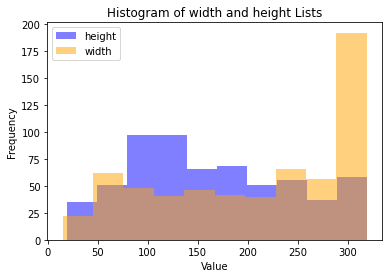

In [36]:
# Create a histogram
plt.hist(heightList, bins=10, alpha=0.5, label='height', color='blue')
plt.hist(widthList, bins=10, alpha=0.5, label='width', color='orange')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of width and height Lists')
plt.legend()

# Show the plot
plt.show()

In [37]:
avg_height = sum(heightList) / len(heightList)
avg_width = sum(widthList) / len(widthList)

In [38]:
print(avg_height)
print(avg_width)

162.87967479674796
207.98861788617887


In [39]:
min_var = min(avg_height, avg_width)
desiredShape = round(min_var / 10) * 10
desiredShape

160

In [40]:
if desiredShape < 35:
  desiredShape = 35

In [41]:
#train
num_of_imgs_per_class = []
for tmp_ctr in range(number_of_classes):
    num_of_imgs_per_class.append(0)
if (not running_on_vm) or (running_on_vm and delete_previous_data_set):
  k = 0
  for file_name in os.listdir(mainfolderpath + '/Mask_DS/train/images'):
    file_path = os.path.join(mainfolderpath + '/Mask_DS/train/images',file_name)
    img_shape = cv2.imread(file_path).shape
    txt_path = os.path.join(mainfolderpath + '/Mask_DS/train/labels',file_name[:-3]+"txt")
    classes,xmin,xmax,ymin,ymax = extract_images(txt_path,img_shape)
    i = 0
    for sub_img in xmin:
      im = cv2.imread(file_path)
      im = im [ymin[i]:ymax[i],xmin[i]:xmax[i],:]
      #im = roi_align_image(im)
      down_points = (desiredShape, desiredShape)
      im = cv2.resize(im, down_points, interpolation= cv2.INTER_LINEAR)
      path = mainfolderpath + '/Mask_DS/ClassImages/train/' + class_names[classes[i]]
      num_of_imgs_per_class[classes[i]] += 1
      if not os.path.exists(path):
        os.makedirs(path)
      cv2.imwrite(path + '/' + str(k) + '.jpg', im)
      i = i+1
      k = k+1

In [42]:
#test
if (not running_on_vm) or (running_on_vm and delete_previous_data_set):
  k = 0
  for file_name in os.listdir(mainfolderpath + "/Mask_DS/test/images"):
    file_path = os.path.join(mainfolderpath + "/Mask_DS/test/images",file_name)
    img_shape = cv2.imread(file_path).shape
    txt_path = os.path.join(mainfolderpath + "/Mask_DS/test/labels",file_name[:-3]+"txt")
    classes,xmin,xmax,ymin,ymax = extract_images(txt_path,img_shape)
    i = 0

    for sub_img in xmin:
      im = cv2.imread(file_path)
      im = im [ymin[i]:ymax[i],xmin[i]:xmax[i],:]
      #im = roi_align_image(im)
      down_points = (desiredShape, desiredShape)
      im = cv2.resize(im, down_points, interpolation= cv2.INTER_LINEAR)
      path = mainfolderpath + '/Mask_DS/ClassImages/test/' + class_names[classes[i]]
      if not os.path.exists(path):
        os.makedirs(path)
      cv2.imwrite(path + '/' + str(k) + '.jpg', im)
      #cv2.imwrite(mainfolderpath + '/Mask_DS/ClassImages/train/' + class_names[classes[i]] + '/2_' + str(k) + '.jpg', im)


      i = i+1
      k = k+1

In [43]:

#valid
if (not running_on_vm) or (running_on_vm and delete_previous_data_set):
  k = 0
  for file_name in os.listdir(mainfolderpath + "/Mask_DS/valid/images"):
    file_path = os.path.join(mainfolderpath + "/Mask_DS/valid/images",file_name)
    img_shape = cv2.imread(file_path).shape
    txt_path = os.path.join(mainfolderpath + "/Mask_DS/valid/labels",file_name[:-3]+"txt")
    classes,xmin,xmax,ymin,ymax = extract_images(txt_path,img_shape)
    i = 0

    for sub_img in xmin:
      im = cv2.imread(file_path)
      im = im [ymin[i]:ymax[i],xmin[i]:xmax[i],:]
      #im = roi_align_image(im)
      down_points = (desiredShape, desiredShape)
      im = cv2.resize(im, down_points, interpolation= cv2.INTER_LINEAR)
      path = mainfolderpath + '/Mask_DS/ClassImages/valid/' + class_names[classes[i]]
      #cv2.imwrite(mainfolderpath + '/Mask_DS/ClassImages/train/' + class_names[classes[i]] + '/3_' + str(k) + '.jpg', im)

      if not os.path.exists(path):
        os.makedirs(path)
      cv2.imwrite(path + '/' + str(k) + '.jpg', im)
      i = i+1
      k = k+1

##Dummy Dataset

In [44]:
# dummy_path = mainfolderpath +'/Mask_DS/dummy'

# if not os.path.exists(dummy_path):
#     os.makedirs(dummy_path)

In [45]:
# %cd $dummy_path

# if desiredShape == 640:
# #   ###################  Images 640*640
# #   #Dummy Yolo-Dummy Train DS Augm link : 902 images
#    !curl -L "https://app.roboflow.com/ds/AhKMV7igoc?key=7FOgppgsTi" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# #   #Dummy Yolo-Dummy Valid DS Orig link : 241 images
#    !curl -L "https://app.roboflow.com/ds/7swnAKQKDZ?key=mQPjyA3yhN" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# #   #Dummy Yolo-Dummy Test DS Orig link : 104 images
#    !curl -L "https://app.roboflow.com/ds/V6GGwwgULZ?key=4x3JzVI8Qu" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# if desiredShape == 240:
# #   ###################  Images 240*240

# #   #Dummy Yolo-Dummy Train DS Augm link : 902 images
#    !curl -L "https://app.roboflow.com/ds/lKKAnGqVUa?key=w3uRZAqEic" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# #   #Dummy Yolo-Dummy Valid DS Orig link : 241 images
#    !curl -L "https://app.roboflow.com/ds/CrLPzrQ0Wb?key=vQ4hbqHrdF" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# #   #Dummy Yolo-Dummy Test DS Orig link : 104 images
#    !curl -L "https://app.roboflow.com/ds/CbnG0eiDRN?key=8SYnT0iABy" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# if desiredShape == 120:
# #   #################### Images 120*120
# #   #Dummy Yolo-Dummy Train DS Augm link : 902 images
#    !curl -L "https://app.roboflow.com/ds/kft6WeQpBF?key=U1HsS6VEGu" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# #   #Dummy Yolo-Dummy Valid DS Orig link : 241 images
#    !curl -L "https://app.roboflow.com/ds/4Od9t86XrJ?key=BBgjEHZtmK" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# #   #Dummy Yolo-Dummy Test DS Orig link : 104 images
#    !curl -L "https://app.roboflow.com/ds/AjE8Fq12pC?key=nInVCGMqss" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# # ####################################################
# # #Dummy Yolo-NotGun-Dummy Split DS Augm link : 1326 images
# # #!curl -L "https://app.roboflow.com/ds/TgXxDVnB3F?key=xBebtV4ZOB" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# # #Dummy Yolo-NotGun-Dummy Split DS Orig link : 626 images
# # #!curl -L "https://app.roboflow.com/ds/yU6bHD8t6c?key=tCC4BRCQp5" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# # ####################################################
# # #Dummy train Yolo-Dummy link : 366 images
# # #!curl -L "https://app.roboflow.com/ds/dPMdCnQIiA?key=WtyO1AhCdR" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# # #Dummy train NotGun-Dummy Augmenyed link : 848 images
# # #!curl -L "https://app.roboflow.com/ds/7tG0ldivjM?key=vyxkY9OcLP" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# # #Dummy train NotGun-Dummy Original link : 424 images
# # #!curl -L "https://app.roboflow.com/ds/NHdJeZPyRh?key=hTCXUgcYZx" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# shutil.copytree(dummy_path + "/train/Dummy",mainfolderpath + "/Mask_DS/ClassImages/train/dummy")
# shutil.copytree(dummy_path + "/valid/Dummy",mainfolderpath + "/Mask_DS/ClassImages/valid/dummy")
# shutil.copytree(dummy_path + "/test/Dummy",mainfolderpath + "/Mask_DS/ClassImages/test/dummy")

# shutil.rmtree(dummy_path)

In [46]:
# #Dummy valid link : 152 images
# os.makedirs(dummy_path)
# %cd $dummy_path

# !curl -L "https://app.roboflow.com/ds/R1ksVTAuIU?key=AYgnFsx1o9" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# shutil.copytree(dummy_path + "/train/Dummy",mainfolderpath + "/Mask_DS/ClassImages/valid/dummy")
# shutil.rmtree(dummy_path)

In [47]:
# #Dummy test link : 116 images
# os.makedirs(dummy_path)
# %cd $dummy_path

# !curl -L "https://app.roboflow.com/ds/DIvTNTWY6C?key=7w6kNci1ux" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

# shutil.copytree(dummy_path + "/train/Dummy",mainfolderpath + "/Mask_DS/ClassImages/test/dummy")
# shutil.rmtree(dummy_path)

##Dataset Classes Count

In [48]:
for folder in os.listdir(mainfolderpath + '/Mask_DS/ClassImages'):
    for subfolder in os.listdir(mainfolderpath + '/Mask_DS/ClassImages/' + folder):
        c = 0
        for img in os.listdir(mainfolderpath + '/Mask_DS/ClassImages/' + folder + '/' + subfolder):
            c = c+1
        print(folder + '/' + subfolder + "=====>" + str(c))
    print('___________________________________________')

test/Handgun=====>21
test/Rifle=====>40
___________________________________________
valid/Handgun=====>39
valid/Rifle=====>93
___________________________________________
train/Handgun=====>151
train/Rifle=====>332
___________________________________________


In [49]:
%cd $mainfolderpath

/content/NewCode


# New Model Train Definitions 1

In [50]:
def modified_accuracy(cm_array):
  # Sum of last row and last column
  sum_last_column = cm_array[:, -1].sum()
  sum_last_row = cm_array[-1, :].sum()
  total_sum = sum_last_row + sum_last_column
  # Support (total number of samples)
  support = cm_array.sum()
  # Final result
  result = round(1- (total_sum / support), 3)
  return result

In [51]:
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from google.colab.patches import cv2_imshow
full_model = None
XG_Model = None
Mask_Training_History = None
exp = 0

In [52]:
latest_yolo_train_run = 0

In [53]:
recall_list = []
precision_list = []
f1_list = []
current_epoch = 1
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [54]:
#DIFINITION OF CALL BACKS FUNCTIONS
def call_back_save2drive():
  local_mask_last_path =  mainfolderpath + "/mask_best.h5"
  destination_folder = "/content/drive/MyDrive/NewWeights/"
  destination_last_mask = destination_folder + "mask_best.h5"

  ####delete old files from drive####
  try:
    old_path_last = destination_last_mask
    if os.path.exists(old_path_last):
      os.remove(old_path_last)
  ###################################

  ####delete accidental files from drive#### probably not called


    if os.path.exists(destination_last_mask):
      os.remove(destination_last_mask)
  ###########################################
  except:
      e = 0
  destination_last_mask = destination_last_mask[:-3] + "_"+ str(current_epoch) + ".h5"
  shutil.copy(local_mask_last_path, destination_last_mask)

In [55]:

# from keras.callbacks import ModelCheckpoint
# class Callbacks(keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         global current_epoch
#         global save_per_num_of_epochs
#         #delete_previous_last()
#         if save_per_num_of_epochs !=0 and current_epoch % save_per_num_of_epochs == 0:
#         #  call_back_Calculate_Metrics(logs["loss"],logs["val_loss"])
#         #else:
#         #  extend_statistics(logs["loss"],logs["val_loss"])
#             call_back_save2drive()
#         #if current_epoch % save_per_num_of_epochs == 0:
#         #  call_back_save2drive()
#         #  save_statistics_localy_and_drive()

#         #print("Finished processing epoch " + str(current_epoch).zfill(4))
#         current_epoch = current_epoch + 1
#     def __del__(self):
#         print(' ')
# ms = ModelCheckpoint('mask_best.h5', save_weights_only=True, verbose=1)
# callbacks= [ms,Callbacks()]

In [56]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

In [57]:
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression

# Apply sigmoid to logits for binary classification
def apply_sigmoid(logits):
    return 1 / (1 + np.exp(-logits))

def calibrate_probabilities(raw_outputs, calibration_model="mm"):
    if calibration_model:
        calibrated_probs = calibration_model.predict_proba(raw_outputs)[:, 1]
    else:
        # Simple calibration example
        clf = LogisticRegression(solver='liblinear')
        # Dummy labels: You need real labels for proper calibration
        dummy_labels = np.ones((raw_outputs.shape[0],))
        clf.fit(raw_outputs, dummy_labels)
        calibrated_probs = clf.predict_proba(raw_outputs)[:, 1]
    return calibrated_probs

def mask_predict(image_path, calibration=Apply_Calibration, calibration_model="A"):
    img = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((desiredShape, desiredShape)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        full_model.eval()
        logits = full_model(img).cpu().numpy()
        probs = apply_sigmoid(logits)

        if calibration:
            calibrated_probs = calibrate_probabilities(probs, calibration_model)
            return calibrated_probs
        else:
            return activationFunction(logits)

def Full_Predict(img_path, Apply_XG=False, calibration=False, calibration_model=None):
    if Apply_XG:
        return XG_Model.predict_proba(mask_predict(img_path, calibration, calibration_model))
    else:
        return mask_predict(img_path, calibration, calibration_model)


# New Model Train Definitions 2


In [58]:
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

In [59]:
from keras.preprocessing.image import ImageDataGenerator

In [60]:
original_classes=0

In [61]:
def get_iou(original_box, pred_box): #[xmin, xmax, ymin, ymax]
    # determine the coordinates of the intersection rectangle
    x_left = max(original_box[0], pred_box[0])
    y_top = max(original_box[2], pred_box[2])
    x_right = min(original_box[1], pred_box[1])
    y_bottom = min(original_box[3], pred_box[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (original_box[1] - original_box[0]) * (original_box[3] - original_box[2])
    bb2_area = (pred_box[1] - pred_box[0]) * (pred_box[3] - pred_box[2])
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    return iou

def getOrigninalOfSmallPredicted(original_boxes, orignal_classes, pred_box):
    #[xmin, xmax, ymin, ymax][], [1,1,0,2,3...],[xmin, xmax, ymin, ymax]
    # determine the coordinates of the intersection rectangle
    max_iou = 0
    max_iou_ind = -1
    for i in range(len(original_boxes)):

        iou = get_iou(original_boxes[i], pred_box)
        if iou > max_iou:
            max_iou = iou
            max_iou_ind = i
    if (max_iou < YOLO_Overlap_Thresh):
      max_iou_ind = -1
    if(max_iou_ind == -1):
      return -1
    else:
      return orignal_classes[max_iou_ind]

In [62]:
import os
import torch
import shutil
import numpy
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
import random
import pandas as pd

In [63]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = None
optimizer = None
exp_lr_scheduler = None
mask_acc = 1

In [64]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg16_bn, resnet101, resnet50
from torchvision.models import VGG16_BN_Weights, ResNet101_Weights, ResNet50_Weights, resnet18, ResNet18_Weights
from torch.optim import lr_scheduler
import time
import copy
import os

# Define the model initialization
def init_model():
    global full_model
    global criterion
    global optimizer
    global exp_lr_scheduler

    if not os.path.exists('results'):
        os.makedirs('results')

    if Model_Name == "V16":
        print("VGG16")
        full_model = vgg16_bn(weights=VGG16_BN_Weights.IMAGENET1K_V1)
        if not Apply_XG:
            for param in full_model.features.parameters():
                param.requires_grad = False
            num_features = full_model.classifier[6].in_features
            features = list(full_model.classifier.children())[:-1]
            features.append(nn.Linear(num_features, number_of_classes))
            full_model.classifier = nn.Sequential(*features)

    elif Model_Name == "R101":
        print("RESNET-101")
        full_model = resnet101(weights=ResNet101_Weights.IMAGENET1K_V2)
        if not Apply_XG:
            num_ftrs = full_model.fc.in_features
            full_model.fc = nn.Linear(num_ftrs, number_of_classes)

    elif Model_Name == "R50":
        print("RESNET-50")
        full_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        if not Apply_XG:
            num_ftrs = full_model.fc.in_features
            full_model.fc = nn.Linear(num_ftrs, number_of_classes)

    elif Model_Name == "R18":
        print("RESNET-18")
        full_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        if not Apply_XG:
            num_ftrs = full_model.fc.in_features
            full_model.fc = nn.Linear(num_ftrs, number_of_classes)

    else:
        print("Invalid Model Name")
        return


    full_model = full_model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(full_model.parameters(), lr=mask_LR, momentum=0.9, weight_decay=mask_weight_decay)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=mask_sched_step_size, gamma=mask_sched_gamma)
    mask_acc = 1

    if Direct_Mask_Detection:
        full_model.load_state_dict(torch.load(Mask_Direct_Weights))

    if YoloVersion == "v5":
      # Assuming gopath is the path to your yolov5 code, which might not be relevant here.
      gopath = mainfolderpath + '/yolov5/'
      %cd $gopath  # This is a Jupyter/IPython magic command and should be used in a notebook cell

# Training

In [65]:
# Training the model
def train_mask(dataloaders, dataset_sizes, M_epochs):
    global full_model
    global mask_acc
    since = time.time()

    best_model_wts = copy.deepcopy(full_model.state_dict())
    best_acc = 0.0

    for epoch in range(M_epochs):
        print(f'Epoch {epoch}/{M_epochs - 1}')
        print('-' * 10)

        for phase in ['train']:
            full_model.train()  # Set model to training mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = full_model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            exp_lr_scheduler.step()
            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                mask_acc = best_acc.data.cpu().numpy()
                best_model_wts = copy.deepcopy(full_model.state_dict())

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    full_model.load_state_dict(best_model_wts)
    torch.save(full_model.state_dict(), mainfolderpath + '/mask_best.pt')
    shutil.copy(mainfolderpath + '/mask_best.pt','/content/drive/MyDrive/NewWeights/Mask_Classifier_' + str(epoch) + '.pt')
    return full_model


In [66]:
###################################   Train XGBoost    ###################################

def apply_XGBoost():
        global XG_Model
        XG_Train_Features = []
        Train_labels = []
        for folder in os.listdir(mainfolderpath + '/Mask_DS/ClassImages/train/'):
            folderPath = mainfolderpath + '/Mask_DS/ClassImages/train/' + folder
            for img in os.listdir(folderPath):
              imgPath = folderPath + '/' + img
              XG_Train_Features.append(mask_predict(imgPath))
              Train_labels.append(class_names.index(folder))

        XG_Valid_Features = []
        Valid_labels = []
        for folder in os.listdir(mainfolderpath + '/Mask_DS/ClassImages/valid/'):
            folderPath = mainfolderpath + '/Mask_DS/ClassImages/valid/' + folder
            for img in os.listdir(folderPath):
              imgPath = folderPath + '/' + img
              XG_Valid_Features.append(mask_predict(imgPath))
              Valid_labels.append(class_names.index(folder))

        XG_Train_Features = np.array(XG_Train_Features)
        XG_Train_Features = XG_Train_Features.reshape(XG_Train_Features.shape[0], -1)

        XG_Valid_Features = np.array(XG_Valid_Features)
        XG_Valid_Features = XG_Valid_Features.reshape(XG_Valid_Features.shape[0], -1)

        XG_Model = xgboost.XGBClassifier(learning_rate=XGBoost_LR, n_estimators=XGBoost_n_estimators)

        eval_set = [(XG_Train_Features, Train_labels), (XG_Valid_Features, Valid_labels)]
        XG_Model.fit(
            XG_Train_Features,
            Train_labels,
            eval_metric=["merror"],
            eval_set=eval_set,
            verbose=True
        )

        results = XG_Model.evals_result()

        train_error = results['validation_0']['merror']
        train_acc = [1.0 - i for i in train_error]

        val_error = results['validation_1']['merror']
        val_acc = [1.0 - i for i in val_error]

        train_predictions = XG_Model.predict(XG_Train_Features)
        val_predictions = XG_Model.predict(XG_Valid_Features)

        print ("XG Training Accuracy = ", accuracy_score(Train_labels, train_predictions))
        print ("XG Validation Accuracy = ", accuracy_score(Valid_labels, val_predictions))
        XG_Model.save_model('XG.json')
        return XG_Model

In [67]:

###################################   Train Full Model    ###################################

def train(batch_size,num_epochs_yolo,num_epochs_mask):
        global full_model
        global XG_Model
        global latest_yolo_train_run
        global exp
        global Mask_Training_History

        gopath=mainfolderpath + '/yolo'+ YoloVersion + '/'
        %cd $gopath

        if YoloVersion == "v5" and (not running_on_vm or (running_on_vm and not code_exists_on_vm)):
          with open('train.py') as f:
            model_file = f.read()

          with open('train.py', 'w') as f:
            model_file = model_file.replace("torch.save(ckpt, best)","torch.save(ckpt, best)\n" + "                    print('\\n_____________________________________________NEW BEST at epoch (' + str(epoch) + ')\\n')")
            f.write(model_file)

        if num_epochs_yolo > 0:
            latest_yolo_train_run = latest_yolo_train_run + 1
            Data_Path = mainfolderpath + '/Yolo_DS/data.yaml'
            patience =  yolo_early_stopping

            try:
              shutil.rmtree(mainfolderpath + '/yolov8/runs/detect/train')
            except:
              No_Error = 0

            try:
              shutil.rmtree(mainfolderpath + '/yolov5/runs/train/yolov5s_results')
            except:
              No_Error = 0

            if YoloVersion == "v5":
              !python train.py --img $yolo_image_size --batch $batch_size --epochs $num_epochs_yolo --data $Data_Path --weights $init_yolo --name yolov5s_results --cache --patience $patience
            if YoloVersion == "v8":
              !yolo train model=$init_yolo data=$dPatht epochs=$YOLO_Epochs imgsz=$yolo_image_size batch=$batch_size epochs=$YOLO_Epochs cache=True patience=$patience


            shutil.copy(yolo_w_path,'/content/drive/MyDrive/NewWeights/yolo' + YoloVersion +'_' + str(num_epochs_yolo) + '.pt')

        %cd $mainfolderpath

        if os.path.exists(mainfolderpath + '/YoloDebug'):
          shutil.rmtree(mainfolderpath + '/YoloDebug')

        # Take Dummy from YOLO Detection O/P
        # GenerateDummyAndDebugYolo('train',mainfolderpath + '/Yolo_DS/train/images',yolo_w_path)
        # GenerateDummyAndDebugYolo('test',mainfolderpath + '/Yolo_DS/test/images', yolo_w_path)
        # GenerateDummyAndDebugYolo('valid',mainfolderpath + '/Yolo_DS/valid/images', yolo_w_path)

        # Training and testing folders
        train_path = 'Mask_DS/ClassImages/train/'
        valid_path = 'Mask_DS/ClassImages/valid/'
        test_path = 'Mask_DS/ClassImages/test/'
        # Get train and test files
        image_files = glob(train_path + '/*/*.jp*g')
        valid_image_files = glob(valid_path + '/*/*.jp*g')
        test_files = glob(test_path + '/*/*.jp*g')
        IMAGE_SIZE = [desiredShape, desiredShape]


        transform = transforms.Compose([
            transforms.RandomRotation(30),
            transforms.RandomResizedCrop(IMAGE_SIZE[0]),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])

        Trainset = datasets.ImageFolder(train_path, transform=transform)
        Trainloader = torch.utils.data.DataLoader(Trainset, batch_size=batch_size, shuffle=True)
        data_size = len(Trainset)

        # Fit the model
        if not Direct_Mask_Detection:
          full_model = train_mask(Trainloader, data_size, num_epochs_mask)


        #XGBoost
        if Apply_XG and not Direct_Mask_Detection:
            XG_Model = apply_XGBoost()


# Detection

In [68]:
###################################   Segmentation    ###################################

def segment(img):
        ##Segment Image
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        twoDimage = img.reshape((-1,3))
        twoDimage = np.float32(twoDimage)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        K = 4
        attempts=10
        ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
        center = np.uint8(center)
        res = center[label.flatten()]
        result_image = res.reshape((img.shape))

        #Get Uniqe Colors of Segmentation
        img_unique_colors = []
        for row in result_image:
            for ele in row:
                stored_Before = False
                for stored_col in img_unique_colors:
                    if ele[0] == stored_col[0] and ele[1] == stored_col[1] and ele[2] == stored_col[2]:
                        stored_Before = True;
                        break
                if not stored_Before:
                    img_unique_colors.append(ele)
                    if len(img_unique_colors) == k:
                        break
            if len(img_unique_colors) == k:
                        break

        #Get the darkest segmentation color that represents the weapon
        Darkest_Color = [255,255,255]
        for i in range(K):
            if sum(img_unique_colors[i]) < sum(Darkest_Color):
                Darkest_Color = img_unique_colors[i]

        # segment only the darkest color
        r = 0
        for row in result_image:
            c = 0
            for ele in row:
                if not(ele[0] == Darkest_Color[0] and ele[1] == Darkest_Color[1] and ele[2] == Darkest_Color[2]):
                    result_image[r][c][0] = img[r][c][0]
                    result_image[r][c][1] = img[r][c][1]
                    result_image[r][c][2] = img[r][c][2]
                c = c + 1
            r = r + 1
        # get (x1,y1), (x2,y2) of the darkest color
        x1 = y1 = 0
        x2 = len(result_image) - 1
        y2 = len(result_image[0]) - 1

        for i in range(len(result_image)):
            found = False
            r = i
            for j in range(len(result_image[0])):
                c = j
                if result_image[r][c][0] == Darkest_Color[0] and result_image[r][c][1] == Darkest_Color[1] and Darkest_Color[2]:
                    x1 = r
                    found = True
                    break
            if found:
                break

        for i in range(len(result_image)):
            found = False
            r = len(result_image) - i - 1
            for j in range(len(result_image[0])):
                c = len(result_image[0]) - j - 1
                if result_image[r][c][0] == Darkest_Color[0] and result_image[r][c][1] == Darkest_Color[1] and Darkest_Color[2]:
                    x2 = r
                    found = True
                    break
            if found:
                break

        for j in range(len(result_image[0])):
            found = False
            c = j
            for i in range(len(result_image)):
                r = i
                if result_image[r][c][0] == Darkest_Color[0] and result_image[r][c][1] == Darkest_Color[1] and Darkest_Color[2]:
                    y1 = c
                    found = True
                    break
            if found:
                break

        for j in range(len(result_image[0])):
            found = False
            c = len(result_image[0]) - j - 1
            for i in range(len(result_image)):
                r = len(result_image) - i - 1
                if result_image[r][c][0] == Darkest_Color[0] and result_image[r][c][1] == Darkest_Color[1] and Darkest_Color[2]:
                    y2 = c
                    found = True
                    break
            if found:
                break


        #Draw the inner border
        InnerBorderColor = [254,0,0]
        result_image[x1:x2,y1:y1+2] = InnerBorderColor
        result_image[x1:x1+2,y1:y2] = InnerBorderColor
        result_image[x1:x2,y2:y2+2] = InnerBorderColor
        result_image[x2:x2+2,y1:y2] = InnerBorderColor
        return result_image

In [69]:
###################################   Add Labels and Borders    ###################################

def add_Label_and_border_to_img(im, border_color, img_class, conf):
        im[:,0:3] = border_color
        im[0:3,:] = border_color
        im[:,-3:] = border_color
        im[-3:,:] = border_color
        img_with_border = im
        text_img = np.zeros((25,80,3), np.uint8)
        text_img [:,:] = border_color
        x,y,w,h = 1,5,26,6
        text_color = [x1 - x2 for (x1, x2) in zip([255,255,255], border_color)]
        text_img = cv2.putText(img=text_img, text=str(class_names[img_class] + conf),org=(x + int(w/10),y + int(h/1.5)), fontFace=cv2.FONT_HERSHEY_DUPLEX, fontScale=.6, color=text_color, thickness=1)
        if  text_img.shape[0] < img_with_border.shape[0] and text_img.shape[1] < img_with_border.shape[1]:
              img_with_border[0:text_img.shape[0],0:text_img.shape[1],0:text_img.shape[2]] = text_img
        elif text_img.shape[0] > img_with_border.shape[0] and text_img.shape[1] > img_with_border.shape[1]:
              img_with_border[0:img_with_border.shape[0],0:img_with_border.shape[1],0:img_with_border.shape[2]] = text_img[0:img_with_border.shape[0],0:img_with_border.shape[1],0:img_with_border.shape[2]]
        elif text_img.shape[0] > img_with_border.shape[0] and text_img.shape[1] < img_with_border.shape[1]:
              img_with_border[0:img_with_border.shape[0],0:text_img.shape[1],0:text_img.shape[2]] = text_img[0:img_with_border.shape[0],0:text_img.shape[1],0:text_img.shape[2]]
        elif text_img.shape[0] < img_with_border.shape[0] and text_img.shape[1] > img_with_border.shape[1]:
              img_with_border[0:text_img.shape[0],0:img_with_border.shape[1],0:text_img.shape[2]] = text_img[0:text_img.shape[0],0:img_with_border.shape[1],0:text_img.shape[2]]

        return img_with_border


In [70]:
###################################   Add Labeled Small Images to the Big Image    ###################################

def get_original_image_with_boxes(Data_set_img_path):
            Base_color = [150, 100, 120]
            Border_colors = []
            for c in range(number_of_classes):
                Border_colors.append([(z * c)%254 for z in Base_color])
            original_im = cv2.imread(Data_set_img_path)
            img_shape = original_im.shape
            txt_path = os.path.join("../" , Data_set_img_path [:-3] + "txt")
            txt_path = txt_path.replace('/images/','/labels/')
            classes,xmin,xmax,ymin,ymax = extract_images(txt_path,img_shape)
            i=0
            for sub_img in xmin:
                im = original_im [ymin[i]:ymax[i],xmin[i]:xmax[i],:]
                down_points = (desiredShape, desiredShape)
                im = cv2.resize(im, down_points, interpolation= cv2.INTER_LINEAR)
                Final_class = classes[i]
                border_color = Border_colors[Final_class]
                img_with_border = add_Label_and_border_to_img(im,border_color,Final_class,"")
                req_shape = (original_im [ymin[i]:ymax[i],xmin[i]:xmax[i],:]).shape[0:2]
                img_with_border = cv2.resize(img_with_border,(req_shape[1],req_shape[0]))
                original_im [ymin[i]:ymax[i],xmin[i]:xmax[i],:] = img_with_border
                i = i+1
            return original_im

In [71]:
###################################   Full Detection    ###################################

def detect(test_path,yolo_weights_path = default_yolo_weights_path, plot_res = False):
        global full_model
        global XG_Model
        global exp
        global Mask_Training_History

        goto = 'yolo' + YoloVersion
        %cd $goto
        Border_colors = []
        Base_color = [50, 30, 20]
        for c in range(number_of_classes):
            Border_colors.append([(z * c)%254 for z in Base_color])
        #print(os.listdir('../'))
        exp = exp + 1

        if exp ==1:
          exp_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/detect/' + exp_folder
          labels_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/detect/'+exp_folder+'/labels'
        else:
          exp_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/detect/' + exp_folder + str(exp)
          labels_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/detect/' + exp_folder + str(exp) + '/labels'
        #print("loading_mask")
        #if Direct_Mask_Detection:
            # full_model = torch.load(Mask_Direct_Weights)
        if Apply_XG:
                XG_Model.load(XG_weights_path)
        #print("loading_mask")
        ############For plotting rows
        row_of_images = None
        image_to_draw_ORIGINAL = None
        image_to_draw_YOLO = None
        image_to_draw_Mask = None
        ############################## yolo detection
        if YoloVersion == "v5":
          !python detect.py --weights $yolo_weights_path --img $yolo_image_size --conf 0.4 --source $test_path --save-txt --save-conf --conf-thres $YOLO_Conf_Thresh --iou-thres $YOLO_Overlap_Thresh
        if YoloVersion == "v8":
          !yolo predict model=$yolo_weights_path imgsz=$yolo_image_size conf=.4 source=$test_path save_txt=True save_conf=True conf=$YOLO_Conf_Thresh iou=$YOLO_Overlap_Thresh


        sub_ctr_i = 0
        for file_name in os.listdir(labels_path):#fits the yolo sources --> Detected Images
            image_to_draw_YOLO = cv2.imread(exp_path + "/" + file_name[:-3]+'jpg') # Yolo Result
            image_path = os.path.join(test_path,file_name[:-3]+'jpg')
            print(image_path)
            img_shape = cv2.imread(image_path).shape
            txt_path = os.path.join(labels_path,file_name)
            classes,xmin,xmax,ymin,ymax,yolo_confidences,Image_all_YOlO_Confs = extract_images(txt_path,img_shape,True,True)
            res_txt = ""
            res_file = open(mainfolderpath + "/results/txt/" + file_name[:-3]+"txt", "w")
            original_im = cv2.imread(image_path)
            image_to_draw_ORIGINAL = get_original_image_with_boxes(mainfolderpath + "/Mask_DS/test/images/" + file_name[:-3]+'jpg')

            i=0
            isub_ctr = -1

            for sub_img in xmin:
              isub_ctr = isub_ctr + 1
              im = original_im [ymin[i]:ymax[i],xmin[i]:xmax[i],:]
              down_points = (desiredShape, desiredShape)
              im = cv2.resize(im, down_points, interpolation= cv2.INTER_LINEAR)
              cv2.imwrite('t.jpg',im)
              predictions = Full_Predict("t.jpg")
              curr_class = predictions.argmax()
              if max(predictions[0]) < Mask_THRESH:
                curr_class = dummy_index
            #######################################################################################################


              Mask_class = int(curr_class)
              Yolo_class = int(classes[i])
              Mask_class_probability = round(float(predictions[0][curr_class]),3)
              Final_class = Mask_class


              print("Mask: ")
              print([round(x,3) for x in predictions[0]])
              print("______________________________________________________________________________________________________________________")
              print("______________________________________________________________________________________________________________________")
              #print(Final_class)
              #######################################################################################################
              if str(Final_class) != str(dummy_index):
                res_txt += "element of class: " + str(class_names[Final_class]) + "   "

                Segment_image = original_im [ymin[i]:ymax[i],xmin[i]:xmax[i],:]
                segmented = segment(Segment_image)
                border_color = Border_colors[Final_class]

                img_with_border = add_Label_and_border_to_img(segmented,border_color,Final_class,str(Mask_class_probability))


                req_shape = (original_im [ymin[i]:ymax[i],xmin[i]:xmax[i],:]).shape[0:2]
                img_with_border = cv2.resize(img_with_border,(req_shape[1],req_shape[0]))
                original_im [ymin[i]:ymax[i],xmin[i]:xmax[i],:] = img_with_border  # will cause problem when intersecting --> note for comment


              i = i+1
            image_to_draw_Mask = original_im
            cv2.imwrite(mainfolderpath + '/results/' + file_name[:-3] + "jpg",original_im)
            res_file.write(res_txt)
            if plot_res:
                row_of_images = np.concatenate((image_to_draw_ORIGINAL,image_to_draw_YOLO,image_to_draw_Mask), axis=1)
                cv2_imshow(row_of_images)
                print("\n")

        for file_name in os.listdir(exp_path):#fits the yolo sources --> Undetected Images
          if file_name == "labels":#Skip the labels folder
              continue

          #Check if image is detected before:
          detected_before = False
          for detected_file_name in os.listdir(mainfolderpath + '/results'):
              if file_name[:-3] == detected_file_name[:-3]:
                  detected_before = True
                  break
          if not detected_before:
            if plot_res:
                image_to_draw_ORIGINAL = get_original_image_with_boxes(mainfolderpath + "/Mask_DS/test/images/" + file_name)
                image_to_draw_YOLO = cv2.imread(exp_path + "/"+ file_name[:-3]+'jpg')
                image_to_draw_Mask = cv2.imread(exp_path + "/" + file_name[:-3]+'jpg')
                row_of_images = np.concatenate((image_to_draw_ORIGINAL,image_to_draw_YOLO,image_to_draw_Mask), axis=1)
                cv2_imshow(row_of_images)
                print("\n")
            shutil.copyfile(os.path.join(test_path,file_name),mainfolderpath + '/results/' + file_name)


        %cd $mainfolderpath

# Metrices

In [72]:
###################################   Show Training Graphs    ###################################

def show_graphs():
        global exp
        global Mask_Training_History
        # Start tensorboard
        # Launch after you have started training
        # logs save in the folder "runs"

        #%cd mainfolderpath + '/yolov5/'
        gopath=mainfolderpath + '/yolo' + YoloVersion + '/'
        %cd $gopath
        tb_path = mainfolderpath + '/yolo' + YoloVersion + '/runs'
        %load_ext tensorboard
        %tensorboard --logdir $tb_path
        %cd $mainfolderpath
        """
        Epochs = [i for i in range(1,len(recall_list) +1)]
      ##########################################################################

        # Plot the train and validation loss
        plt.plot(Mask_Training_History.history['loss'], label='train loss')
        plt.plot(Mask_Training_History.history['val_loss'], label='val loss')
        plt.legend()
        plt.show()

        # Plot the train and validation accuracies
        plt.plot(Mask_Training_History.history['accuracy'], label='train acc')
        plt.plot(Mask_Training_History.history['val_accuracy'], label='val acc')
        plt.legend()
        plt.show()

        plt.plot(Epochs,recall_list, label='Recall')
        plt.legend()
        plt.show()

        plt.plot(Epochs,precision_list, label='Precision')
        plt.legend()
        plt.show()

        plt.plot(Epochs,f1_list, label='F1-Score')
        plt.legend()
        plt.show()
        """


In [73]:
###################################   Show Full Model Merices    ###################################

def show_metrics(valid_test, yolo_weights_path = default_yolo_weights_path ):# valid_test = 0 ->validation///valid_test = 1 ->test
      global full_model
      global XG_Model
      global exp
      global Mask_Training_History
      test_path = ""
      if valid_test == 0:
          test_path = mainfolderpath + '/Mask_DS/valid/images'
      elif valid_test == 1:
          test_path = mainfolderpath + '/Mask_DS/test/images'


      exp = exp + 1
      if exp ==1:
            exp_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/detect/' + exp_folder
            labels_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/detect/'+ exp_folder +'/labels'
      else:
            exp_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/detect/' + exp_folder + str(exp)
            labels_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/detect/' + exp_folder + str(exp) + '/labels'

      go_path = mainfolderpath + '/yolo' + YoloVersion + ''
      %cd $go_path
      if YoloVersion == "v5":
          !python detect.py --weights $yolo_weights_path --img $yolo_image_size --conf 0.4 --source $test_path --save-txt --save-conf --conf-thres $YOLO_Conf_Thresh --iou-thres $YOLO_Overlap_Thresh
      if YoloVersion == "v8":
          !yolo predict model=$yolo_weights_path imgsz=$yolo_image_size conf=.4 source=$test_path save_txt=True save_conf=True conf=$YOLO_Conf_Thresh iou=$YOLO_Overlap_Thresh

      %cd $mainfolderpath

      if Direct_Mask_Detection:
          # full_model = torch.load(Mask_Direct_Weights)
          if Apply_XG:
              XG_Model.load(XG_weights_path)

      original_classes = []
      pred_classes = []
      for img_name in os.listdir(test_path):
          file_path = os.path.join(test_path,img_name)
          img_shape = cv2.imread(file_path).shape
          txt_path = ""
          if valid_test == 0:
              txt_path = os.path.join(mainfolderpath + '/Mask_DS/valid/labels',img_name[:-3]+"txt")
          elif valid_test == 1:
              txt_path = os.path.join(mainfolderpath + '/Mask_DS/test/labels',img_name[:-3]+"txt")
          actual_classes,actual_xmin,actual_xmax,actual_ymin,actual_ymax = extract_images(txt_path,img_shape)



          txt_path = os.path.join(labels_path,img_name[:-3]+"txt")
          yolo_classes = []
          try:
            yolo_classes,yolo_xmin,yolo_xmax,yolo_ymin,yolo_ymax,yolo_confidences,Image_all_YOlO_Confs = extract_images(txt_path,img_shape,True, True)
          except:
            yolo_classes,yolo_xmin,yolo_xmax,yolo_ymin,yolo_ymax,yolo_confidences,Image_all_YOlO_Confs = [],[],[],[],[],[],[]

          Final_classes = []
          i = 0
          isub_ctr = -1
          original_im = cv2.imread(file_path)
          for sub_img in yolo_xmin:
              isub_ctr = isub_ctr + 1
              im = original_im [yolo_ymin[i]:yolo_ymax[i],yolo_xmin[i]:yolo_xmax[i],:]
              down_points = (desiredShape, desiredShape)
              im = cv2.resize(im, down_points, interpolation= cv2.INTER_LINEAR)
              cv2.imwrite('t.jpg',im)
              predictions = Full_Predict("t.jpg")
              curr_class = predictions.argmax()
              if max(predictions[0]) < Mask_THRESH:
                curr_class = dummy_index
              clear_output(wait=False)

              #######################################################################################################

              Mask_class = int(curr_class)
              Mask_class_probability = round(float(predictions[0][curr_class]),3)
              sub_ctr_i = 0

              Final_class = Mask_class

              Final_classes.append(Final_class)
              i = i+1


              ################################################################################################
          Not_Found_actual = []
          for act_cls in actual_classes:
              # check if the actual class is in the Final_classes
              # and delete it if so:
              ind_ctr = 0
              found = False
              while ind_ctr < len(Final_classes):
                  if act_cls == Final_classes[ind_ctr]:
                      original_classes.append(class_names[act_cls])
                      pred_classes.append(class_names[Final_classes[ind_ctr]])
                      del Final_classes[ind_ctr]
                      found = True
                      break
                  ind_ctr = ind_ctr + 1
              if not found:
                  Not_Found_actual.append(act_cls)

          rem_act_ctr = 0
          rem_pre_ctr = 0
          while rem_act_ctr < len(Not_Found_actual):
              original_classes.append(class_names[Not_Found_actual[rem_act_ctr]])
              if rem_pre_ctr < len(Final_classes) and Final_classes[rem_pre_ctr] != dummy_index:
                  pred_classes.append(class_names[Final_classes[rem_pre_ctr]])
                  del Final_classes[rem_pre_ctr]
              elif rem_pre_ctr < len(Final_classes):
                  pred_classes.append('dummy')
                  del Final_classes[rem_pre_ctr]
              else:
                  pred_classes.append('dummy')


              rem_act_ctr = rem_act_ctr + 1
              rem_pre_ctr = rem_pre_ctr + 1
          # Actual is empty now#
          for ele in Final_classes:
              original_classes.append("dummy")
              pred_classes.append(class_names[ele])
    ##########################################################################################
      labels = class_names
      labels.append('dummy')
      cm_labels = np.unique(labels)
      cm_array = confusion_matrix(original_classes, pred_classes)
      cm_array[number_of_classes,number_of_classes] = 0
      cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
      ax = sns.heatmap(cm_array_df, annot=True, cmap='Reds')
      ax.set_title('Confusion Matrix\n\n');
      ax.set_xlabel('\nPredicted Values')
      ax.set_ylabel('Actual Values');
      plt.show()
      mod_acc = modified_accuracy(cm_array)

      cm_labels = np.unique(labels)
      cm_array = confusion_matrix(original_classes, pred_classes, normalize = "true")
      cm_array[number_of_classes,number_of_classes] = 0
      cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
      ax = sns.heatmap(cm_array_df, annot=True, cmap='Reds')
      ax.set_title('Normalized Confusion Matrix\n\n');
      ax.set_xlabel('\nPredicted Values')
      ax.set_ylabel('Actual Values');
      plt.show()

      accuracy,AVG_Precision,AVG_Recall,AVG_F1,MAP50in,MAP95in,MAP50,MAP95=Get_Stats(original_classes,pred_classes)
      print('Accuracy = ', str(accuracy))
      print('Modified Accuracy = ', str(mod_acc))
      print('Average Precisison = ', str(AVG_Precision))
      print('Average Recall = ', str(AVG_Recall))
      print('Average F1-Score = ', str(AVG_F1))
      print('MASK_mAP@.5: ' + str(round(MAP50in,2)) + "  " + 'MASK_mAP@.5:.95: ' + str(round(MAP95in,2)))
      print('ROI_mAP@.5: ' + str(round(MAP50,2)) + "  " + 'ROI_mAP@.5:.95: ' + str(round(MAP95,2)))
      try:
            shutil.rmtree(exp_path) # Folder for test images confusion matrix
            exp = exp -1
      except:
            No_Error = 0


In [74]:
###################################   Show Yolo Metrices    ###################################

def yolo_Matrix(valid_test, yolo_weights_path = default_yolo_weights_path): # valid_test = 0 ->validation///valid_test = 1 ->test
      global exp
      test_path = ""
      if valid_test == 0:
          test_path = mainfolderpath + '/Yolo_DS/valid/images'
      elif valid_test == 1:
          test_path = mainfolderpath + '/Yolo_DS/test/images'


      exp = exp + 1
      if exp ==1:
            exp_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/detect/' + exp_folder
            labels_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/detect/' + exp_folder +'/labels'
      else:
            exp_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/detect/' + exp_folder + str(exp)
            labels_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/detect/' + exp_folder + str(exp) + '/labels'

      go_path = mainfolderpath + '/yolo' + YoloVersion + ''
      %cd $go_path
      if YoloVersion == "v5":
          !python detect.py --weights $yolo_weights_path --img $yolo_image_size --conf 0.4 --source $test_path --save-txt --save-conf --conf-thres $YOLO_Conf_Thresh --iou-thres $YOLO_Overlap_Thresh
      if YoloVersion == "v8":
          !yolo predict model=$yolo_weights_path imgsz=$yolo_image_size conf=.4 source=$test_path save_txt=True save_conf=True conf=$YOLO_Conf_Thresh iou=$YOLO_Overlap_Thresh
      %cd $mainfolderpath


      original_classes = []
      pred_classes = []
      for img_name in os.listdir(test_path):
          file_path = os.path.join(test_path,img_name)
          img_shape = cv2.imread(file_path).shape
          txt_path = ""
          if valid_test == 0:
              txt_path = os.path.join(mainfolderpath + '/Yolo_DS/valid/labels',img_name[:-3]+"txt")
          elif valid_test == 1:
              txt_path = os.path.join(mainfolderpath + '/Yolo_DS/test/labels',img_name[:-3]+"txt")
          actual_classes,actual_xmin,actual_xmax,actual_ymin,actual_ymax = extract_images(txt_path,img_shape)



          txt_path = os.path.join(labels_path,img_name[:-3]+"txt")
          yolo_classes = []
          try:
            yolo_classes,yolo_xmin,yolo_xmax,yolo_ymin,yolo_ymax,yolo_confidences,Image_all_YOlO_Confs = extract_images(txt_path,img_shape,True, True)
          except:
            yolo_classes,yolo_xmin,yolo_xmax,yolo_ymin,yolo_ymax,yolo_confidences,Image_all_YOlO_Confs = [],[],[],[],[],[],[]

          Final_classes = []
          i = 0
          isub_ctr = -1
          original_im = cv2.imread(file_path)
          for sub_img in yolo_xmin:
              isub_ctr = isub_ctr + 1
              clear_output(wait=False)
              Yolo_class = int(yolo_classes[i])
              Final_class = int(Yolo_class)
              Final_classes.append(Final_class)
              i = i+1

          Not_Found_actual = []
          for act_cls in actual_classes:
              # check if the actual class is in the Final_classes
              # and delete it if so:
              ind_ctr = 0
              found = False
              while ind_ctr < len(Final_classes):
                  if act_cls == Final_classes[ind_ctr] and act_cls != dummy_index:
                      original_classes.append(class_names[act_cls])
                      pred_classes.append(class_names[Final_classes[ind_ctr]])
                      del Final_classes[ind_ctr]
                      found = True
                      break
                  ind_ctr = ind_ctr + 1
              if not found:
                  if act_cls != dummy_index:
                      Not_Found_actual.append(act_cls)

          rem_act_ctr = 0
          rem_pre_ctr = 0
          while rem_act_ctr < len(Not_Found_actual):
              if Not_Found_actual[rem_act_ctr]!= dummy_index:
                  original_classes.append(class_names[Not_Found_actual[rem_act_ctr]])
                  if rem_pre_ctr < len(Final_classes) and Final_classes[rem_pre_ctr] != dummy_index:
                      pred_classes.append(class_names[Final_classes[rem_pre_ctr]])
                      del Final_classes[rem_pre_ctr]
                  elif rem_pre_ctr < len(Final_classes):
                      pred_classes.append('dummy')
                      del Final_classes[rem_pre_ctr]
                  else:
                      pred_classes.append('dummy')
              else:
                  if rem_pre_ctr < len(Final_classes) and Final_classes[rem_pre_ctr] != dummy_index:
                      original_classes.append("dummy")
                      pred_classes.append(class_names[Final_classes[rem_pre_ctr]])
                      del Final_classes[rem_pre_ctr]
                  elif rem_pre_ctr < len(Final_classes):
                      del Final_classes[rem_pre_ctr]

              rem_act_ctr = rem_act_ctr + 1
              rem_pre_ctr = rem_pre_ctr + 1
          # Actual is empty now#
          for ele in Final_classes:
              if ele != dummy_index:
                  original_classes.append("dummy")
                  pred_classes.append(class_names[ele])
    ##########################################################################################
      labels = ["Weapon"]
      labels.append('dummy')
      cm_labels = np.unique(labels)
      cm_array = confusion_matrix(original_classes, pred_classes)
      cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
      ax = sns.heatmap(cm_array_df, annot=True, cmap='Blues')
      ax.set_title('Confusion Matrix\n\n');
      ax.set_xlabel('\nPredicted Values')
      ax.set_ylabel('Actual Values');
      plt.show()
      mod_acc = modified_accuracy(cm_array)

      cm_labels = np.unique(labels)
      cm_array = confusion_matrix(original_classes, pred_classes, normalize = "true")
      cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
      ax = sns.heatmap(cm_array_df, annot=True, cmap='Blues')
      ax.set_title('Normalized Confusion Matrix\n\n');
      ax.set_xlabel('\nPredicted Values')
      ax.set_ylabel('Actual Values');
      plt.show()

      accuracy,AVG_Precision,AVG_Recall,AVG_F1,MAP50in,MAP95in,MAP50,MAP95=Get_Stats(original_classes,pred_classes)
      print('Accuracy = ', str(accuracy))
      print('Modified Accuracy = ', str(mod_acc))
      print('Average Precisison = ', str(AVG_Precision))
      print('Average Recall = ', str(AVG_Recall))
      print('Average F1-Score = ', str(AVG_F1))
      try:
            shutil.rmtree(exp_path) # Folder for test images confusion matrix
            exp = exp -1
      except:
            No_Error = 0

# Train

In [75]:
import datetime
tme = datetime.datetime.utcnow()+datetime.timedelta(hours=2)
print(tme.strftime('%H:%M:%S'))

05:56:07


In [76]:
from keras.callbacks import EarlyStopping,ModelCheckpoint
init_model()

RESNET-101
[Errno 2] No such file or directory: '/content/NewCode/yolov5/ # This is a Jupyter/IPython magic command and should be used in a notebook cell'
/content/NewCode


In [77]:
print (set_batch)
print (desiredShape)

32
160


In [78]:
train(batch_size=set_batch,num_epochs_yolo=yolo_epochs,num_epochs_mask=mask_epochs)

/content/NewCode/yolov5
/content/NewCode
Epoch 0/99
----------
train Loss: 0.5003 Acc: 0.7329
Epoch 1/99
----------
train Loss: 0.3171 Acc: 0.8737
Epoch 2/99
----------
train Loss: 0.2851 Acc: 0.8965
Epoch 3/99
----------
train Loss: 0.2186 Acc: 0.8986
Epoch 4/99
----------
train Loss: 0.2177 Acc: 0.9151
Epoch 5/99
----------
train Loss: 0.2151 Acc: 0.9172
Epoch 6/99
----------
train Loss: 0.2129 Acc: 0.9213
Epoch 7/99
----------
train Loss: 0.2520 Acc: 0.8841
Epoch 8/99
----------
train Loss: 0.2090 Acc: 0.9110
Epoch 9/99
----------
train Loss: 0.1885 Acc: 0.9172
Epoch 10/99
----------
train Loss: 0.1731 Acc: 0.9337
Epoch 11/99
----------
train Loss: 0.1811 Acc: 0.9317
Epoch 12/99
----------
train Loss: 0.1818 Acc: 0.9172
Epoch 13/99
----------
train Loss: 0.1690 Acc: 0.9358
Epoch 14/99
----------
train Loss: 0.1434 Acc: 0.9565
Epoch 15/99
----------
train Loss: 0.1546 Acc: 0.9296
Epoch 16/99
----------
train Loss: 0.0982 Acc: 0.9689
Epoch 17/99
----------
train Loss: 0.1090 Acc: 0.95

In [79]:
import datetime
tme = datetime.datetime.utcnow()+datetime.timedelta(hours=2)
print(tme.strftime('%H:%M:%S'))

06:05:21


In [80]:
for folder in os.listdir(mainfolderpath + '/Mask_DS/ClassImages'):
    for subfolder in os.listdir(mainfolderpath + '/Mask_DS/ClassImages/' + folder):
        c = 0
        for img in os.listdir(mainfolderpath + '/Mask_DS/ClassImages/' + folder + '/' + subfolder):
            c = c+1
        print(folder + '/' + subfolder + "=====>" + str(c))
    print('___________________________________________')

test/Handgun=====>21
test/Rifle=====>40
___________________________________________
valid/Handgun=====>39
valid/Rifle=====>93
___________________________________________
train/Handgun=====>151
train/Rifle=====>332
___________________________________________


# Auto Classifier Thresh.

In [81]:
def extract_thresh(mode,test_path,yolo_weights_path):
      global original_classes
      global exp

      yolo_classes_Names = ['Weapon']
      yolo_number_of_classes=(yolo_classes_Names)
      exp = exp + 1
      if exp ==1:
            exp_path = mainfolderpath + '/yolo' + YoloVersion + '/runs/detect/' + exp_folder
            labels_path = mainfolderpath +  '/yolo' + YoloVersion + '/runs/detect/' + exp_folder + '/labels'
      else:
            exp_path = mainfolderpath +  '/yolo' + YoloVersion + '/runs/detect/' + exp_folder + str(exp)
            labels_path = mainfolderpath +  '/yolo' + YoloVersion + '/runs/detect/' + exp_folder + str(exp) + '/labels'

      print(exp_path)
      print(labels_path)




      weapon_probs.append(Mask_THRESH)
      weapon_probs.append(1)
      dummy_probs.append(Mask_THRESH)
      dummy_probs.append(1)
      go_path = mainfolderpath +  '/yolo' + YoloVersion
      %cd $go_path
      if YoloVersion == "v5":
          !python detect.py --weights $yolo_weights_path --img $yolo_image_size --conf 0.4 --source $test_path --save-txt --save-conf --conf-thres $YOLO_Conf_Thresh --iou-thres $YOLO_Overlap_Thresh
      if YoloVersion == "v8":
          !yolo predict model=$yolo_weights_path imgsz=$yolo_image_size conf=0.4 source=$test_path save_txt=True save_conf=True conf=$YOLO_Conf_Thresh iou=$YOLO_Overlap_Thresh

      %cd $mainfolderpath


      original_classes = []
      pred_classes = []
      newDummyITR = 0;

      for img_name in os.listdir(test_path):
          file_path = os.path.join(test_path,img_name)
          original_im = cv2.imread(file_path)
          img_shape = cv2.imread(file_path).shape
          txt_path = os.path.join(mainfolderpath + '/Yolo_DS/'+mode+'/labels',img_name[:-3]+"txt")
          actual_classes,actual_xmin,actual_xmax,actual_ymin,actual_ymax = extract_images(txt_path,img_shape)
          txt_path = os.path.join(labels_path,img_name[:-3]+"txt")
          ################################for debugging
          test_pathYolo = mainfolderpath + '/YoloDebug/' + mode + '/' + img_name[:-4]
          # if os.path.exists(test_pathYolo):
          #     shutil.rmtree(test_pathYolo)
          # os.makedirs(test_pathYolo)
          im = cv2.imread(file_path)
          # print("_________________________________________________________________________")
          # print("_________________________________________________________________________")
          # print("_________________________________________________________________________")
          # print("_________________________________________________________________________")


          # image_to_draw_YOLO = cv2.imread(exp_path + "/" + img_name[:-3]+'jpg') # Yolo Result
          # row_of_images = np.concatenate((get_original_image_with_boxes(file_path),image_to_draw_YOLO), axis=1)
          # cv2_imshow(row_of_images)
          # cv2.imwrite(test_pathYolo + '/Big.jpg',row_of_images)
          #########################################


          yolo_classes = []
          try:
            yolo_classes,yolo_xmin,yolo_xmax,yolo_ymin,yolo_ymax,yolo_confidences,Image_all_YOlO_Confs = extract_images(txt_path,img_shape,True, True)
          except:
            yolo_classes,yolo_xmin,yolo_xmax,yolo_ymin,yolo_ymax,yolo_confidences,Image_all_YOlO_Confs = [],[],[],[],[],[],[]

          Final_classes = []
          small_images = []
          j = 0
          original_im = cv2.imread(file_path)

          Orininal_boxes = []
          for k in range(len(actual_xmin)):
              Orininal_boxes.append([actual_xmin[k],actual_xmax[k],actual_ymin[k],actual_ymax[k]])

          Pred_boxes = []
          for k in range(len(yolo_xmin)):
              Pred_boxes.append([yolo_xmin[k],yolo_xmax[k],yolo_ymin[k],yolo_ymax[k]])

          for sub_img in yolo_classes:
              im = original_im [yolo_ymin[j]:yolo_ymax[j],yolo_xmin[j]:yolo_xmax[j],:]
              down_points = (desiredShape, desiredShape)
              im = cv2.resize(im, down_points, interpolation= cv2.INTER_LINEAR)
              cv2.imwrite('t.jpg',im)
              predictions = Full_Predict('t.jpg')

              mask_class = predictions.argmax()
              mask_prob = max(predictions[0])
              img_class = getOrigninalOfSmallPredicted(Orininal_boxes, actual_classes,Pred_boxes[j])
              if(mask_prob >= init_Mask_THRESH): #ignore less than thresh
                  detected_probs.append(mask_prob)
                  if (img_class == -1):
                      dummy_probs.append(mask_prob)
                  else:
                      weapon_probs.append(mask_prob)
              j = j+1

In [82]:
detected_probs = []
weapon_probs = []
dummy_probs = []
# extract_thresh('test', mainfolderpath + '/Yolo_DS/test/images',yolo_w_path) # Should not use Test DS
extract_thresh('valid', mainfolderpath + '/Yolo_DS/valid/images',yolo_w_path)
extract_thresh('train', mainfolderpath + '/Yolo_DS/train/images',yolo_w_path)

/content/NewCode/yolov5/runs/detect/exp
/content/NewCode/yolov5/runs/detect/exp/labels
/content/NewCode/yolov5
YOLOv5 🚀 v7.0-399-g8cc44963 Python-3.8.16 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/117 /content/NewCode/Yolo_DS/valid/images/1-100-_jpg.rf.53ce7ad1c3f41fdc17c1c348c7f31bcc.jpg: 320x320 1 Weapon, 7.8ms
image 2/117 /content/NewCode/Yolo_DS/valid/images/1-101-_jpg.rf.443e02dea073b8f124d520eb4cb27200.jpg: 320x320 1 Weapon, 7.6ms
image 3/117 /content/NewCode/Yolo_DS/valid/images/1-105-_jpg.rf.a830c54aea991c18d5db61d9df5d0384.jpg: 320x320 1 Weapon, 7.7ms
image 4/117 /content/NewCode/Yolo_DS/valid/images/1-110-_jpg.rf.2535fb70afa21e0a6d93ab526cc39683.jpg: 320x320 2 Weapons, 8.5ms
image 5/117 /content/NewCode/Yolo_DS/valid/images/1-127-_jpg.rf.5794523eb771b60f8cb5e86c1df427c3.jpg: 320x320 1 Weapon, 7.8ms
image 6/117 /content/NewCode/Yolo_DS/valid/images/1-130-_jpg.rf.ed249867516db1

In [83]:
print('number of all detected yolo instances = ' + str(len(detected_probs)))
print('number of weapon detected yolo instances = ' + str(len(weapon_probs)))
print('number of dummy detected yolo instances = ' + str(len(dummy_probs)))

number of all detected yolo instances = 642
number of weapon detected yolo instances = 606
number of dummy detected yolo instances = 44


In [84]:
print('overall avg thresh = ' + str(sum(detected_probs)/len(detected_probs)))
print('weapon avg thresh = ' + str(sum(weapon_probs)/len(weapon_probs)))
print('dummy avg thresh = ' + str(sum(dummy_probs)/len(dummy_probs)))

overall avg thresh = 0.9770901922681993
weapon avg thresh = 0.9789081266020784
dummy avg thresh = 0.8653086071664636


In [85]:
his_step_size = .01
integ_step_size = .05

In [86]:
his_nbins = int(np.ceil((1- init_Mask_THRESH) / his_step_size))
print(his_nbins)

60


In [87]:
nbins = int(np.ceil((1- init_Mask_THRESH) / integ_step_size))
print(nbins)

12


In [88]:
his_nbins = [ round(init_Mask_THRESH + n * (his_step_size), 3) for n in range(his_nbins + 1)]
print(his_nbins)

[0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0]


In [89]:
nbins = [ round(init_Mask_THRESH + n * (integ_step_size), 3) for n in range(nbins + 1)]
print(nbins)

[0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


### TP

---TP Histogram---


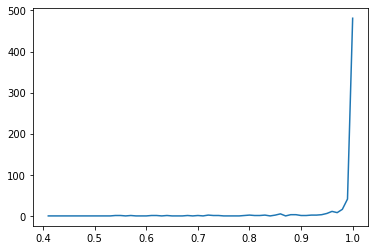

---TP Integration---


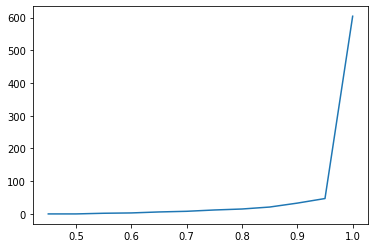

---Reversed TP---


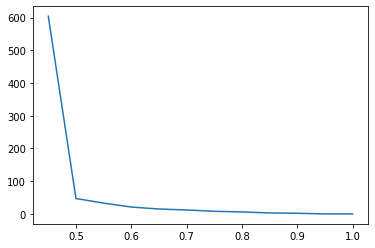

In [90]:
w_hist, his_bins  = np.histogram(weapon_probs, his_nbins)

temp_w_hist, bins  = np.histogram(weapon_probs, nbins)
w_integ = np.cumsum(temp_w_hist)
reversed_w_integ = w_integ[::-1]

plt.plot(his_bins[1:],w_hist)
print("---TP Histogram---")
plt.show()

plt.plot(bins[1:],w_integ)
print("---TP Integration---")
plt.show()

plt.plot(bins[1:],reversed_w_integ)
print("---Reversed TP---")
plt.show()

In [91]:
print("---reversed_w_integ---")
print(reversed_w_integ)

TP_dif_1 = [ reversed_w_integ[i - 1] - x for i, x in enumerate(reversed_w_integ)][1:]
print("---TP_dif_1---")
print(TP_dif_1)

TP_dif_2 = [ TP_dif_1[i - 1] - x for i, x in enumerate(TP_dif_1)][1:]
print("---TP_dif_2---")
print(TP_dif_2)

TP_selected_bin_index = TP_dif_2.index(max(TP_dif_2))
print(TP_selected_bin_index)

---reversed_w_integ---
[604  47  33  21  15  12   8   6   3   2   0   0]
---TP_dif_1---
[557, 14, 12, 6, 3, 4, 2, 3, 1, 2, 0]
---TP_dif_2---
[543, 2, 6, 3, -1, 2, -1, 2, -1, 2]
0


## FP

---FP Histogram---


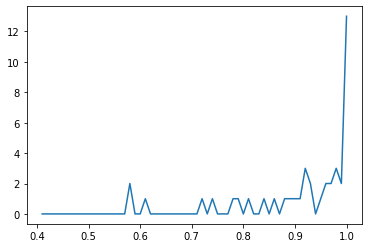

---FP Integration---


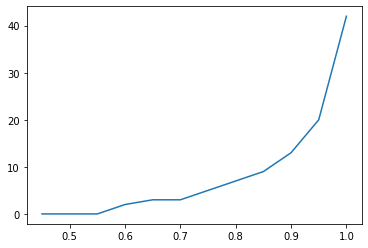

---Reversed FP---


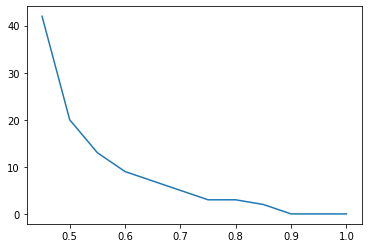

In [92]:
d_hist, his_bins  = np.histogram(dummy_probs, his_nbins)

temp_d_hist, bins  = np.histogram(dummy_probs, nbins)
d_integ = np.cumsum(temp_d_hist)
reversed_d_integ = d_integ[::-1]

plt.plot(his_bins[1:], d_hist)
print("---FP Histogram---")
plt.show()

plt.plot(bins[1:], d_integ)
print("---FP Integration---")
plt.show()

plt.plot(bins[1:],reversed_d_integ)
print("---Reversed FP---")
plt.show()

In [93]:
print("---reversed_d_integ---")
print(reversed_d_integ)

FP_dif_1 = [reversed_d_integ[i - 1] - x for i, x in enumerate(reversed_d_integ)][1:]
print("---FP_dif_1---")
print(FP_dif_1)

FP_dif_2 = [-1 * (FP_dif_1[i - 1] - x) for i, x in enumerate(FP_dif_1)][1:]
print("---FP_dif_2---")
print(FP_dif_2)

FP_selected_bin_index = FP_dif_2.index(max(FP_dif_2)) + 2
print(FP_selected_bin_index)

---reversed_d_integ---
[42 20 13  9  7  5  3  3  2  0  0  0]
---FP_dif_1---
[22, 7, 4, 2, 2, 2, 0, 1, 2, 0, 0]
---FP_dif_2---
[-15, -3, -2, 0, 0, -2, 1, 1, -2, 0]
8


## Final

In [94]:
bins

array([        0.4,        0.45,         0.5,        0.55,         0.6,        0.65,         0.7,        0.75,         0.8,        0.85,         0.9,        0.95,           1])

In [95]:
# Mask_THRESH = sum(dummy_probs)/len(dummy_probs)
Mask_THRESH = (bins[FP_selected_bin_index] + bins[TP_selected_bin_index])/ 2
print('Mask_THRESH = ' + str(Mask_THRESH))

Mask_THRESH = 0.6000000000000001


In [96]:
Mask_THRESH = 0.5

#YOLO Validation

In [97]:
%cd $mainfolderpath

/content/NewCode


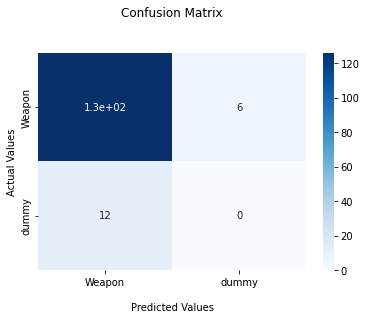

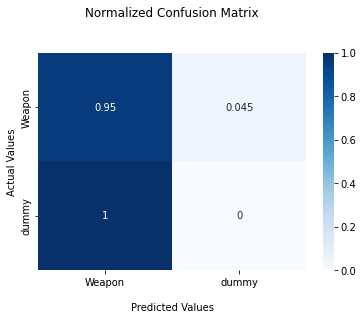

              precision    recall  f1-score   support
     Handgun       0.91      0.95      0.93       132
Accuracy =  0.875
Modified Accuracy =  0.875
Average Precisison =  0.91
Average Recall =  0.95
Average F1-Score =  0.93


In [98]:
yolo_Matrix(valid_test=0, yolo_weights_path  = yolo_w_path)

# Classifier Validation

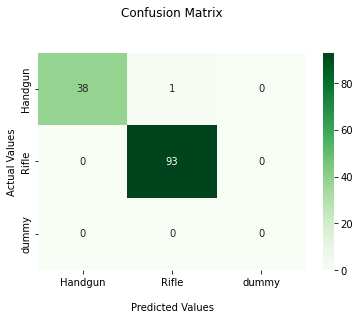

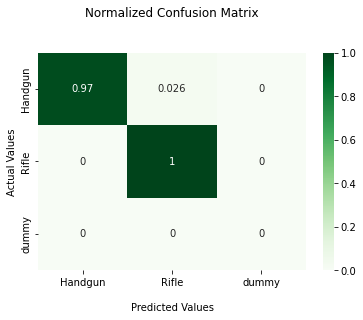

              precision    recall  f1-score   support
     Handgun       1.00      0.97      0.99        39
       Rifle       0.99      1.00      0.99        93
Accuracy =  0.993
Modified Accuracy =  1.0
Average Precisison =  0.995
Average Recall =  0.985
Average F1-Score =  0.99


In [99]:
# Validate classifier only:
actual_list = []
pred_list = []
if Direct_Mask_Detection:
      # full_model = torch.load(Mask_Direct_Weights)
      if Apply_XG:
        XG_Model.load(XG_weights_path)
for folder in os.listdir(os.path.join(mainfolderpath,'Mask_DS/ClassImages/valid')):
    for img in os.listdir(os.path.join(mainfolderpath,'Mask_DS/ClassImages/valid',folder)):
        im = cv2.imread(os.path.join(mainfolderpath,'Mask_DS/ClassImages/valid',folder,img))
        down_points = (desiredShape, desiredShape)
        im = cv2.resize(im, down_points, interpolation= cv2.INTER_LINEAR)
        cv2.imwrite('t.jpg',im)
        predictions = Full_Predict('t.jpg')
        curr_class = predictions.argmax()
        if max(predictions[0]) < Mask_THRESH:
                curr_class = dummy_index
        if curr_class == dummy_index:
            pred_list.append('dummy')
        else:
            pred_list.append(class_names[curr_class])
        actual_list.append(folder)

clear_output(wait=False)
cm_labels = np.unique(actual_list)
if len(cm_labels) != number_of_classes+1:
    for i in range(2):
        actual_list.append('dummy')
        pred_list.append('dummy')
cm_labels = np.unique(actual_list)

cm_array = confusion_matrix(actual_list, pred_list)
cm_array[number_of_classes,:] = 0
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
ax = sns.heatmap(cm_array_df, annot=True, cmap='Greens')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');
plt.show()

mod_acc = modified_accuracy(cm_array)



cm_labels = np.unique(actual_list)
cm_labels = np.unique(actual_list)
cm_array = confusion_matrix(actual_list, pred_list, normalize = "true")
cm_array[number_of_classes,:] = 0
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
ax = sns.heatmap(cm_array_df, annot=True, cmap='Greens')
ax.set_title('Normalized Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');
plt.show()

report_lines = classification_report(actual_list,pred_list).splitlines()
Precisions = []
Recalls = []
F1s = []
print(report_lines[0])
for ele in report_lines[2:]:
    if 'dummy' in ele:
        break
    else:
        print(ele) #print the line from report
        metrics_list = ele.split(' ')
        metrics_list = [mm for mm in metrics_list if mm]
        Precisions.append(float(metrics_list[1])) #classes should be of one word (No_spaces)
        Recalls.append(float(metrics_list[2]))
        F1s.append(float(metrics_list[3]))

AVG_Precision = round(sum(Precisions)/len(Precisions),3)
AVG_Recall = round(sum(Recalls)/len(Precisions),3)
AVG_F1 = round(sum(F1s)/len(Precisions),3)
idx_ctr = 0
correct_ctr = 0
All_ctr = 0
for ele in actual_list:
    if actual_list[idx_ctr] == pred_list[idx_ctr]:#old--> and original_classes[idx_ctr] != 'dummy':
        correct_ctr += 1
        All_ctr += 1
    else:#old-->if original_classes[idx_ctr] != 'dummy':
        All_ctr += 1
    idx_ctr += 1


accuracy = round((correct_ctr/All_ctr),3)
modified_accuracy(cm_array)
print('Accuracy = ', str(accuracy))
print('Modified Accuracy = ', str(mod_acc))
print('Average Precisison = ', str(AVG_Precision))
print('Average Recall = ', str(AVG_Recall))
print('Average F1-Score = ', str(AVG_F1))

#YOLO Test

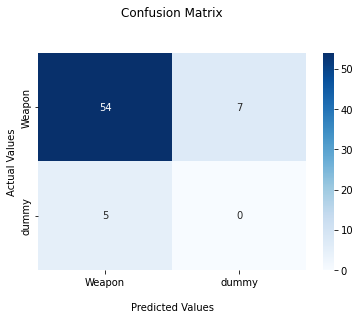

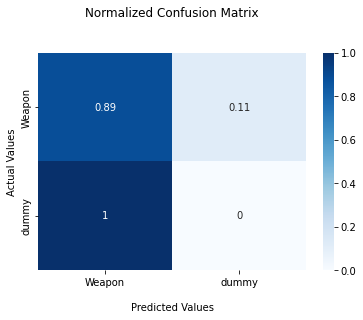

              precision    recall  f1-score   support
     Handgun       0.92      0.89      0.90        61
Accuracy =  0.818
Modified Accuracy =  0.818
Average Precisison =  0.92
Average Recall =  0.89
Average F1-Score =  0.9


In [100]:
yolo_Matrix(valid_test=1,yolo_weights_path  = yolo_w_path)

#Classifier Test

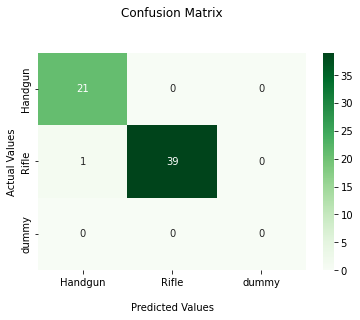

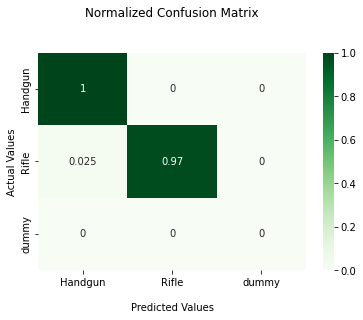

              precision    recall  f1-score   support
     Handgun       0.95      1.00      0.98        21
       Rifle       1.00      0.97      0.99        40
Accuracy =  0.984
Modified Accuracy =  1.0
Average Precisison =  0.975
Average Recall =  0.985
Average F1-Score =  0.985


In [101]:
# test classifier only:
actual_list = []
pred_list = []
if Direct_Mask_Detection:
      # full_model = torch.load(Mask_Direct_Weights)
      if Apply_XG:
        XG_Model.load(XG_weights_path)
for folder in os.listdir(os.path.join(mainfolderpath,'Mask_DS/ClassImages/test')):
    for img in os.listdir(os.path.join(mainfolderpath,'Mask_DS/ClassImages/test',folder)):
        im = cv2.imread(os.path.join(mainfolderpath,'Mask_DS/ClassImages/test',folder,img))
        down_points = (desiredShape, desiredShape)
        im = cv2.resize(im, down_points, interpolation= cv2.INTER_LINEAR)
        cv2.imwrite('t.jpg',im)
        predictions = Full_Predict('t.jpg')
        curr_class = predictions.argmax()
        if max(predictions[0]) < Mask_THRESH:
                curr_class = dummy_index
        if curr_class == dummy_index:
            pred_list.append('dummy')
        else:
            pred_list.append(class_names[curr_class])
        actual_list.append(folder)

clear_output(wait=False)
cm_labels = np.unique(actual_list)
if len(cm_labels) != number_of_classes+1:
    for i in range(2):
        actual_list.append('dummy')
        pred_list.append('dummy')
cm_labels = np.unique(actual_list)

cm_array = confusion_matrix(actual_list, pred_list)
cm_array[number_of_classes,:] = 0
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
ax = sns.heatmap(cm_array_df, annot=True, cmap='Greens')
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');
plt.show()
mod_acc = modified_accuracy(cm_array)


cm_labels = np.unique(actual_list)
cm_labels = np.unique(actual_list)
cm_array = confusion_matrix(actual_list, pred_list, normalize = "true")
cm_array[number_of_classes,:] = 0
cm_array_df = pd.DataFrame(cm_array, index=cm_labels, columns=cm_labels)
ax = sns.heatmap(cm_array_df, annot=True, cmap='Greens')
ax.set_title('Normalized Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values');
plt.show()

report_lines = classification_report(actual_list,pred_list).splitlines()
Precisions = []
Recalls = []
F1s = []
print(report_lines[0])
for ele in report_lines[2:]:
    if 'dummy' in ele:
        break
    else:
        print(ele) #print the line from report
        metrics_list = ele.split(' ')
        metrics_list = [mm for mm in metrics_list if mm]
        Precisions.append(float(metrics_list[1])) #classes should be of one word (No_spaces)
        Recalls.append(float(metrics_list[2]))
        F1s.append(float(metrics_list[3]))

AVG_Precision = round(sum(Precisions)/len(Precisions),3)
AVG_Recall = round(sum(Recalls)/len(Precisions),3)
AVG_F1 = round(sum(F1s)/len(Precisions),3)
idx_ctr = 0
correct_ctr = 0
All_ctr = 0
for ele in actual_list:
    if actual_list[idx_ctr] == pred_list[idx_ctr]:#old--> and original_classes[idx_ctr] != 'dummy':
        correct_ctr += 1
        All_ctr += 1
    else:#old-->if original_classes[idx_ctr] != 'dummy':
        All_ctr += 1
    idx_ctr += 1


accuracy = round((correct_ctr/All_ctr),3)
print('Accuracy = ', str(accuracy))
print('Modified Accuracy = ', str(mod_acc))
print('Average Precisison = ', str(AVG_Precision))
print('Average Recall = ', str(AVG_Recall))
print('Average F1-Score = ', str(AVG_F1))

# New Model Validation

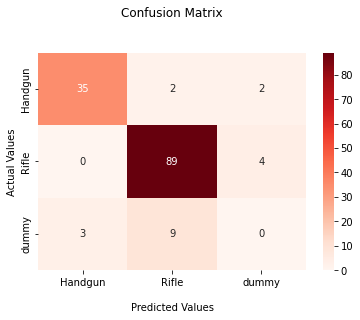

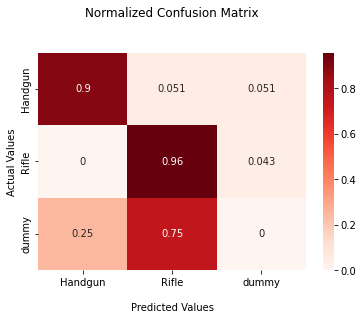

              precision    recall  f1-score   support
     Handgun       0.92      0.90      0.91        39
       Rifle       0.89      0.96      0.92        93
Accuracy =  0.861
Modified Accuracy =  0.875
Average Precisison =  0.905
Average Recall =  0.93
Average F1-Score =  0.915
MASK_mAP@.5: 0.91  MASK_mAP@.5:.95: 0.64
ROI_mAP@.5: 0.83  ROI_mAP@.5:.95: 0.46


In [102]:
show_metrics(valid_test=0,yolo_weights_path  = yolo_w_path)

# New Model Test

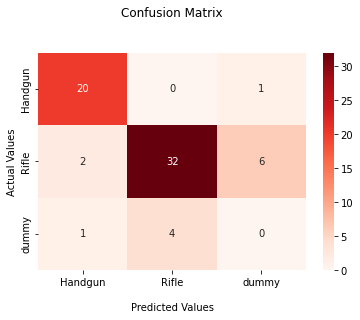

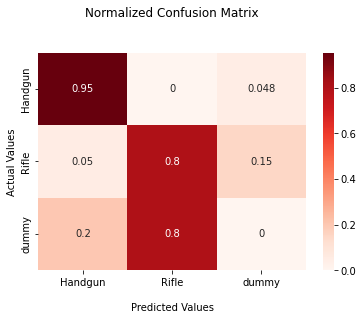

              precision    recall  f1-score   support
     Handgun       0.87      0.95      0.91        21
       Rifle       0.89      0.80      0.84        40
Accuracy =  0.788
Modified Accuracy =  0.818
Average Precisison =  0.88
Average Recall =  0.875
Average F1-Score =  0.875
MASK_mAP@.5: 0.87  MASK_mAP@.5:.95: 0.61
ROI_mAP@.5: 0.79  ROI_mAP@.5:.95: 0.44


In [103]:
show_metrics(valid_test=1,yolo_weights_path  = yolo_w_path)

#Images Display

In [104]:
# creat 5 test folders
source_path = mainfolderpath + '/Mask_DS/test/images'
dest_paths = [mainfolderpath + '/Mask_DS/test0_images',
              mainfolderpath + '/Mask_DS/test1_images',
              mainfolderpath + '/Mask_DS/test2_images',
              mainfolderpath + '/Mask_DS/test3_images',
              mainfolderpath + '/Mask_DS/test4_images']

for path in dest_paths:
    if not os.path.exists(path):
        os.makedirs(path)
copied_images_count = 0
current_dest = 0
for img in os.listdir(mainfolderpath + '/Mask_DS/test/images'):
    current_dest = copied_images_count % 5
    shutil.copy(os.path.join(mainfolderpath + '/Mask_DS/test/images', img) , os.path.join(dest_paths[current_dest],img))
    copied_images_count = copied_images_count + 1

In [105]:
for path in dest_paths:
    print(len(os.listdir(path)))

12
12
11
11
11


In [106]:
d_path = mainfolderpath + '/DebugBigImages'
if os.path.exists(d_path):
    shutil.rmtree(d_path)

In [107]:
detect(test_path = dest_paths[0],yolo_weights_path=yolo_w_path,plot_res=True)

Output hidden; open in https://colab.research.google.com to view.

In [108]:
detect(test_path = dest_paths[1],yolo_weights_path=yolo_w_path,plot_res=True)

Output hidden; open in https://colab.research.google.com to view.

In [109]:
detect(test_path = dest_paths[2],yolo_weights_path=yolo_w_path,plot_res=True)

Output hidden; open in https://colab.research.google.com to view.

In [110]:
detect(test_path = dest_paths[3],yolo_weights_path=yolo_w_path,plot_res=True)

Output hidden; open in https://colab.research.google.com to view.

In [111]:
detect(test_path = dest_paths[4],yolo_weights_path=yolo_w_path,plot_res=True)

Output hidden; open in https://colab.research.google.com to view.

In [112]:
for path in dest_paths:
    shutil.rmtree(path)

In [113]:
import datetime
tme = datetime.datetime.utcnow()+datetime.timedelta(hours=2)
print(tme.strftime('%H:%M:%S'))

06:07:51


#Debug Images

In [114]:
# import shutil
# shutil.make_archive('/content/NewCode/FullModelImages', 'zip', "/content/NewCode/FullModelDebug")
# shutil.make_archive('/content/NewCode/YoloImages', 'zip', "/content/NewCode/YoloDebug")

In [115]:
# ###################################   Full Detection    ###################################

# def DebugFullModel(mode, test_path,yolo_weights_path = mainfolderpath + '/yolov5/runs/train/yolov5s_results/weights/best.pt',mask_weights_path = ""):
#         global full_model
#         global XG_Model
#         global exp
#         global Mask_Training_History
#         %cd yolov5
#         Border_colors = []
#         Base_color = [50, 30, 20]
#         for c in range(number_of_classes):
#             Border_colors.append([(z * c)%254 for z in Base_color])
#         #print(os.listdir('../'))
#         exp = exp + 1
#         if exp ==1:
#           exp_path = mainfolderpath + '/yolov5/runs/detect/exp'
#           labels_path = mainfolderpath + '/yolov5/runs/detect/exp/labels'
#         else:
#           exp_path = mainfolderpath + '/yolov5/runs/detect/exp' + str(exp)
#           labels_path = mainfolderpath + '/yolov5/runs/detect/exp' + str(exp) + '/labels'
#         #print("loading_mask")
#         if Direct_Mask_Detection:
#             full_model = torch.load(Mask_Direct_Weights)
#             if Apply_XG:
#                 XG_Model.load(XG_weights_path)
#         #print("loading_mask")

#         !python detect.py --weights $yolo_weights_path --img 448 --conf 0.4 --source $test_path --save-txt --save-conf --conf-thres $YOLO_Conf_Thresh --iou-thres $YOLO_Overlap_Thresh
#         # yolo detection

#         sub_ctr_i = 0
#         for file_name in os.listdir(labels_path):#fits the yolo sources --> Detected Images
#             image_path = os.path.join(test_path,file_name[:-3]+'jpg')
#             img_shape = cv2.imread(image_path).shape
#             txt_path = os.path.join(labels_path,file_name)
#             classes,xmin,xmax,ymin,ymax,yolo_confidences,Image_all_YOlO_Confs = extract_images(txt_path,img_shape,True,True)
#             res_txt = ""
#             res_file = open(mainfolderpath + "/results/txt/" + file_name[:-3]+"txt", "w")
#             original_im = cv2.imread(image_path)

#             i=0
#             isub_ctr = -1


#             ############################## For Debugging
#             test_pathFullModel = mainfolderpath + '/FullModelDebug/' + mode + '/' + file_name[:-4]
#             if os.path.exists(test_pathFullModel):
#                 shutil.rmtree(test_pathFullModel)
#             os.makedirs(test_pathFullModel)
#             im = cv2.imread(image_path)

#             image_to_draw_YOLO = cv2.imread(exp_path + "/" + file_name[:-3]+'jpg') # Yolo Result
#             row_of_images = np.concatenate((get_original_image_with_boxes(image_path),image_to_draw_YOLO), axis=1)
#             # cv2_imshow(row_of_images)
#             cv2.imwrite(test_pathFullModel + '/Big.jpg',row_of_images)
#             ##############################

#             for sub_img in xmin:
#               isub_ctr = isub_ctr + 1
#               im = original_im [ymin[i]:ymax[i],xmin[i]:xmax[i],:]
#               down_points = (desiredShape, desiredShape)
#               im = cv2.resize(im, down_points, interpolation= cv2.INTER_LINEAR)
#               cv2.imwrite('t.jpg',im)
#               predictions = Full_Predict("t.jpg")
#               curr_class = predictions.argmax()
#               if max(predictions[0]) < Mask_THRESH:
#                 curr_class = dummy_index
#             #######################################################################################################


#               Mask_class = int(curr_class)
#               Yolo_class = int(classes[i])
#               Mask_class_probability = round(float(predictions[0][curr_class]),3)
#               Final_class = Mask_class

#               if Mask_class_probability < Mask_THRESH:
#                       Final_class = number_of_classes-1
#               ############################## For Debugging
#               cv2.imwrite(test_pathFullModel + '/' + str(isub_ctr) + '__' +str(class_names[Final_class]) + '.jpg', im)
#               ##############################

#               #######################################################################################################
#               if str(Final_class) != str(number_of_classes-1):
#                 res_txt += "element of class: " + str(class_names[Final_class]) + "   "







#               i = i+1

#         for file_name in os.listdir(exp_path):#fits the yolo sources --> Undetected Images
#           if file_name == "labels":#Skip the labels folder
#               continue

#           #Check if image is detected before:
#           detected_before = False
#           for detected_file_name in os.listdir(mainfolderpath + '/results'):
#               if file_name[:-3] == detected_file_name[:-3]:
#                   detected_before = True
#                   break
#           if not detected_before:
#             shutil.copyfile(os.path.join(test_path,file_name),mainfolderpath + '/results/' + file_name)


#         %cd $mainfolderpath

In [116]:
# if Direct_YOLO_Detection:
#     weights_path = Yolo_Direct_Weights
# else:
#     weights_path = mainfolderpath + '/yolov5/runs/train/yolov5s_results/weights/best.pt'

# if os.path.exists(mainfolderpath + '/FullModelDebug'):
#   shutil.rmtree(mainfolderpath + '/FullModelDebug')

# #DebugFullModel('train',mainfolderpath + '/Yolo_DS/train/images',weights_path)
# DebugFullModel('test',mainfolderpath + '/Yolo_DS/test/images', weights_path)
# #DebugFullModel('valid',mainfolderpath + '/Yolo_DS/valid/images', weights_path)

In [117]:
# shutil.make_archive('testfull', 'zip','/content/NewCode/FullModelDebug/test')

In [118]:
# shutil.make_archive('testDebug', 'zip','/content/NewCode/YoloDebug/test')
# shutil.make_archive('validDebug', 'zip','/content/NewCode/YoloDebug/train')
# shutil.make_archive('trainDebug', 'zip','/content/NewCode/YoloDebug/valid')